In [1]:
import numpy as np
import pandas as pd
import pymatgen as mg
import time
import os
import seaborn as sns
#from dcor import distcorr, distcorr_array
#import collections

import matplotlib.pyplot as plt
%matplotlib inline

#import matplotlib as mpl

import sys
if '..' not in sys.path:
    sys.path.insert(1,'..')
    
from helpers.calc_chemfeat_2 import Perovskite
from helpers.featurizers import PerovskiteProperty
from helpers import fileload as fl
from helpers.outlier_detect import DataCleaner
import helpers.model_eval as mv
import helpers.feature_select as fs

from sklearn.model_selection import KFold, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.pipeline import Pipeline

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from ipywidgets import interact, interact_manual, fixed

%load_ext autoreload
%autoreload 2

loaded calc_chemfeat_2
Created MatProjCalc instance
loaded featurizers


C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



# Load & clean data 

In [2]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/conductivity')
plotdir = os.path.join(tcodir,'scripts/conductivity/plots')
src = 'samples'

def sampledir(sample,src):
    return os.path.join(datadir,src,sample)

"Load data files"
data = pd.DataFrame()
samples = next(os.walk(os.path.join(datadir,src)))[1]

for sample in samples:
    if sample!='ignore':
        df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':['dry']})
        fl.get_formula(df,overwrite=True)
        df['sample'] = sample
        df.index = df.index + '_' + sample[-4:]
        data = data.append(df,sort=True)

#get el amts after formula normalization - needed for DataCleaner
Bsite = ['Co','Fe','Zr','Y'] #for B-site normalization
for idx in data.index:
    formula = data.loc[idx,'formula']
    comp = mg.Composition(formula)
    Bsum = sum([comp.get(el) for el in Bsite])
    for el in ['Ba'] + Bsite:
        #normalize to B-site
        data.loc[idx,el] = comp.get(el)/Bsum    
    
#remove negative values
data = data.loc[data['Sigma_elec']>=0,:]

data['log_sigma'] = np.log10(data['Sigma_elec'])

"Remove outliers"
dc = DataCleaner(data,'log_sigma',comp_dims=['Ba'] + Bsite)
dc.set_IF_params(contamination=0.15)
dc.fit_predict(z_thresh=1)
dc.remove_outliers()
df = dc.clean_data.loc[:,['sample','Point','formula','Sigma_elec','log_sigma']]

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



# Featurize dataframe

In [3]:
pp = PerovskiteProperty.from_preset('BCFZY')
pp.set_featurize_options(sites=['B','comp'])
featurized = pp.featurize_dataframe(df,col_id='formula',inplace=False)

HBox(children=(IntProgress(value=0, description='PerovskiteProperty', max=496, style=ProgressStyle(description_width='initial')), HTML(value='')))

In [4]:
featurized.head()

,sample,Point,formula,Sigma_elec,log_sigma,comp_oxmin_goldschmidt,comp_oxmin_goldschmidt_struct,comp_oxmin_tau,comp_oxmin_tot_cat_charge,comp_oxmin_anion_delta,...,comp_valence_unfilled_d_range,comp_valence_unfilled_f_mean,comp_valence_unfilled_f_std,comp_valence_unfilled_f_range,comp_polarizability_mean,comp_polarizability_std,comp_polarizability_range,comp_sigma_therm_mean,comp_sigma_therm_std,comp_sigma_therm_range
1_500C_dry_1251,PDAC_COM3_01251,1,Ba0.96661Co0.39251Fe0.47442Y0.0Zr0.13307O3,0.000016,-4.807415,0.992770,2.0,3.420198,4.199360,0.03339,...,8.0,0.0,0.0,0.0,10.085616,19.683882,38.898,19.680210,43.338016,99.97342
2_500C_dry_1251,PDAC_COM3_01251,2,Ba0.96761Co0.39187Fe0.47506Y0.0Zr0.13306O3,0.000015,-4.810406,0.992760,2.0,3.420200,4.201362,0.03238,...,8.0,0.0,0.0,0.0,10.091678,19.688179,38.898,19.677289,43.323369,99.97342
3_500C_dry_1251,PDAC_COM3_01251,3,Ba0.96861Co0.39123Fe0.47571Y0.0Zr0.13306O3,0.000014,-4.838679,0.992749,2.0,3.420202,4.203340,0.03139,...,8.0,0.0,0.0,0.0,10.097750,19.692388,38.898,19.674496,43.308683,99.97342
4_500C_dry_1251,PDAC_COM3_01251,4,Ba0.96766Co0.41426Fe0.46485Y0.0Zr0.12089O3,0.000014,-4.847826,0.992785,2.0,3.420195,4.177100,0.03234,...,8.0,0.0,0.0,0.0,10.064643,19.686528,38.898,19.907178,43.756259,99.97342
5_500C_dry_1251,PDAC_COM3_01251,5,Ba0.96786Co0.41307Fe0.4645Y0.0Zr0.12244O3,0.000016,-4.801500,0.992809,2.0,3.420190,4.180578,0.03215,...,8.0,0.0,0.0,0.0,10.069012,19.687442,38.898,19.884647,43.717985,99.97342


In [5]:
nonfeature_cols = ['sample','Point','formula','Sigma_elec','log_sigma']
response_col = 'log_sigma'

dt = featurized.drop(nonfeature_cols,axis=1).dtypes
nonnumeric_cols = list(dt[dt==np.dtype('O')].index)
nan_cols = [k for k,v in featurized.isnull().max(axis=0).items() if v is True]
drop = nonfeature_cols + nonnumeric_cols + nan_cols

"Set up dataframes and arrays"
#data matrix
X_df = featurized.drop(drop,axis=1)
#standardized data matrix
ss = StandardScaler()
Xs = ss.fit_transform(X_df)

#response
y = featurized.loc[:,response_col].values
#data matrix with response inserted at first column
Xy_df = X_df.copy()
Xy_df.insert(0,response_col,y)
#cluster labels (samples)
clusters = featurized['sample'].values

# Sequential feature selection

In [6]:
X_df.head()

,comp_oxmin_goldschmidt,comp_oxmin_goldschmidt_struct,comp_oxmin_tau,comp_oxmin_tot_cat_charge,comp_oxmin_anion_delta,comp_oxmin_alat_hardsphere,comp_oxmin_uc_vol,comp_oxmin_uc_vol_free,comp_oxmin_r_crit,comp_oxmax_goldschmidt,...,comp_valence_unfilled_d_range,comp_valence_unfilled_f_mean,comp_valence_unfilled_f_std,comp_valence_unfilled_f_range,comp_polarizability_mean,comp_polarizability_std,comp_polarizability_range,comp_sigma_therm_mean,comp_sigma_therm_std,comp_sigma_therm_range
1_500C_dry_1251,0.992770,2.0,3.420198,4.199360,0.03339,4.186072,73.353379,24.475398,0.886408,1.083702,...,8.0,0.0,0.0,0.0,10.085616,19.683882,38.898,19.680210,43.338016,99.97342
2_500C_dry_1251,0.992760,2.0,3.420200,4.201362,0.03238,4.186072,73.353379,24.464849,0.886424,1.083683,...,8.0,0.0,0.0,0.0,10.091678,19.688179,38.898,19.677289,43.323369,99.97342
3_500C_dry_1251,0.992749,2.0,3.420202,4.203340,0.03139,4.186072,73.353379,24.454493,0.886440,1.083663,...,8.0,0.0,0.0,0.0,10.097750,19.692388,38.898,19.674496,43.308683,99.97342
4_500C_dry_1251,0.992785,2.0,3.420195,4.177100,0.03234,4.186072,73.353379,24.476583,0.886387,1.085298,...,8.0,0.0,0.0,0.0,10.064643,19.686528,38.898,19.907178,43.756259,99.97342
5_500C_dry_1251,0.992809,2.0,3.420190,4.180578,0.03215,4.186072,73.353379,24.473465,0.886352,1.085143,...,8.0,0.0,0.0,0.0,10.069012,19.687442,38.898,19.884647,43.717985,99.97342


## Random forest

In [205]:
rf = RandomForestRegressor()

sfs_rf = SFS(rf,
          k_features=5,
          forward=True,
          floating=True,
          verbose=2,
          scoring='r2',
          cv=KFold(3,shuffle=True),
          n_jobs=4
)

start = time.time()
sfs_rf.fit(Xs,y,custom_feature_names=X_df.columns.values)
print('Fit time:',time.time() - start)

[Parallel(n_jobs=4)]: Done  37 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 327 out of 334 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    5.9s finished

[2019-03-05 18:57:15] Features: 1/5 -- score: 0.9922978949174532[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    6.7s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.6s finished

[2019-03-05 18:57:24] Features: 2/5 -- score: 0.993994763428785[Parallel(n_jobs=4)]: Done  35 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:    6.9s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.9s finished

[2019-03-05 18:57:34] Features: 3/5 -- score: 0.9943991535767572[Parallel(n_jobs=4)]: Done  35 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    1.0s f

Fit time: 46.73228120803833


In [206]:
sfs_rf.subsets_

{1: {'avg_score': 0.9922978949174532,
  'cv_scores': array([0.99533697, 0.98514002, 0.9964167 ]),
  'feature_idx': (52,),
  'feature_names': ('comp_oxrange_uc_vol_free',)},
 2: {'avg_score': 0.993994763428785,
  'cv_scores': array([0.9964824 , 0.99784306, 0.98765883]),
  'feature_idx': (52, 139),
  'feature_names': ('comp_oxrange_uc_vol_free', 'comp_oxmedian_tot_charge')},
 3: {'avg_score': 0.9943991535767572,
  'cv_scores': array([0.9982486 , 0.9981836 , 0.98676527]),
  'feature_idx': (52, 139, 145),
  'feature_names': ('comp_oxrange_uc_vol_free',
   'comp_oxmedian_tot_charge',
   'comp_oxstd_r_std')},
 4: {'avg_score': 0.9949320169707935,
  'cv_scores': array([0.99768541, 0.99874337, 0.98836727]),
  'feature_idx': (38, 52, 139, 145),
  'feature_names': ('comp_oxstd_tau',
   'comp_oxrange_uc_vol_free',
   'comp_oxmedian_tot_charge',
   'comp_oxstd_r_std')},
 5: {'avg_score': 0.9947769318294203,
  'cv_scores': array([0.99695885, 0.98874729, 0.99862466]),
  'feature_idx': (29, 38, 52, 1

<IPython.core.display.Javascript object>


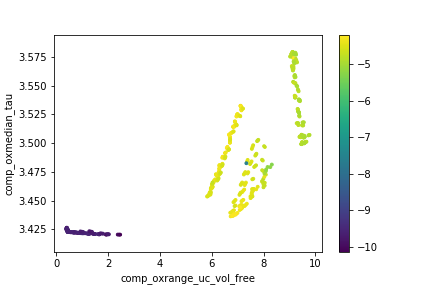

In [209]:
fig, ax = plt.subplots()
f1,f2 = sfs_rf.k_feature_names_[0:2]
#f1='Bsite_multivalent_frac'
f1 = 'comp_oxrange_uc_vol_free'
f2 = 'comp_oxmedian_tau'
p = ax.scatter(Xy_df[f1],Xy_df[f2],c=y,s=8)
ax.set_xlabel(f1)
ax.set_ylabel(f2)
fig.colorbar(p)

In [ ]:
#bin log_sigma values for pairplot hue
bins = np.arange(np.floor(min(y)),np.ceil(max(y))+0.5,0.5)
y_bin = np.digitize(y,bins)
Xy_df['y_bin'] = [bins[yb] for yb in y_bin]

<IPython.core.display.Javascript object>


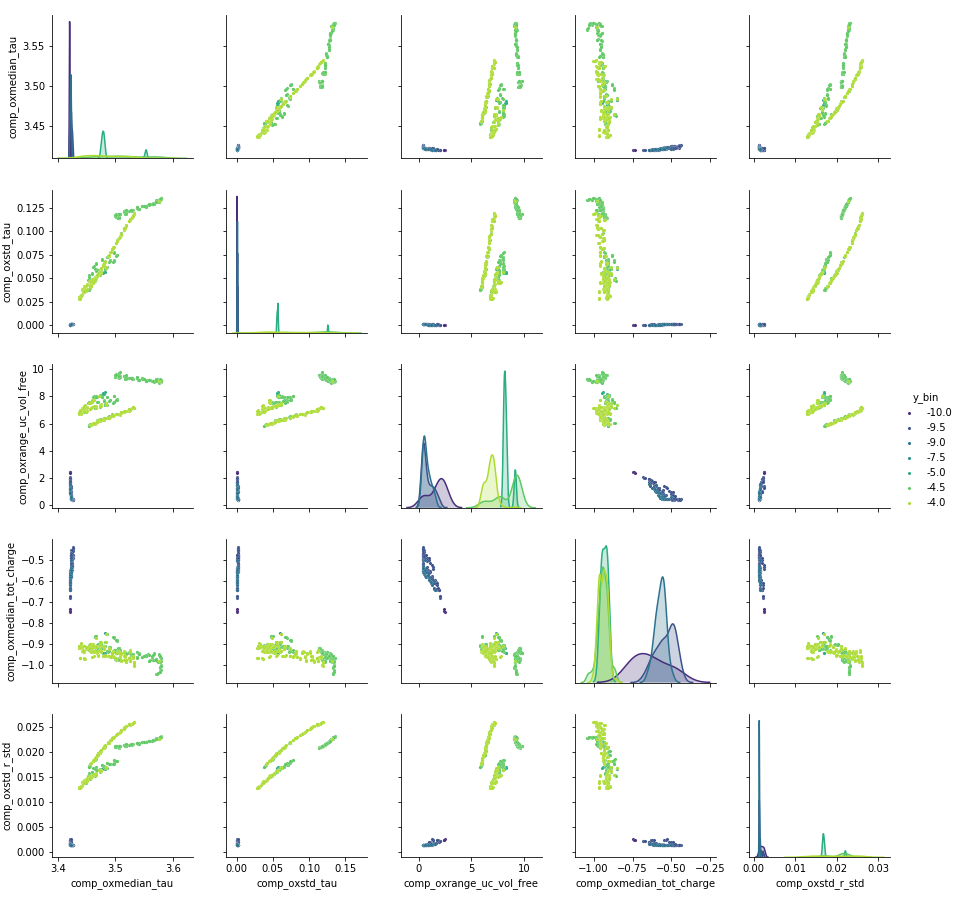

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\bandwidths.py:22: RuntimeWarning:

invalid value encountered in minimum

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce



In [208]:
sns.pairplot(Xy_df,vars=list(sfs_rf.k_feature_names_),diag_kind='kde',hue='y_bin',palette='viridis',
             plot_kws={'s':10,'linewidth':0.1})

Test cluster PDAC_COM3_01251
Test cluster PDAC_COM3_01254
Test cluster PDAC_COM3_01255
Test cluster PDAC_COM3_01256
Train scores:  [0.99795443 0.99917553 0.88758753 0.99774267] 
	Mean train score:  0.9706150413355944
Test scores:  [-6.91040653e+00 -2.72981859e-01 -5.50337746e+02 -1.73022674e+00] 
	Mean test score:  -139.8128403230335


<IPython.core.display.Javascript object>


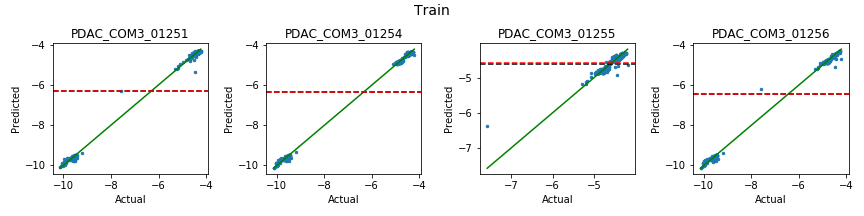

<IPython.core.display.Javascript object>


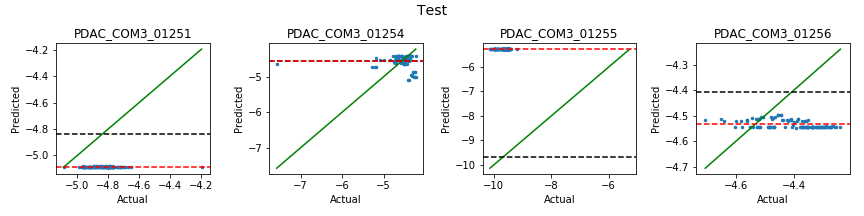

<IPython.core.display.Javascript object>


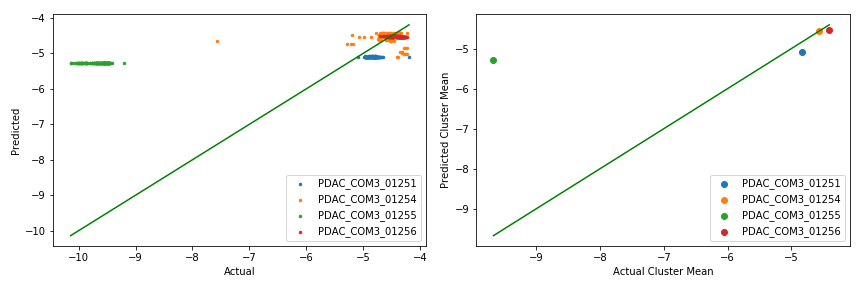

In [207]:
X_red = X_df.loc[:,sfs_rf.k_feature_names_].values
Xrs = ss.fit_transform(X_red)
mv.plot_loco_cv(RandomForestRegressor,Xrs,y,clusters,ncol=4,n_estimators=100,max_depth=5)#e-1)

## Ridge regression

In [212]:
sfs

SequentialFeatureSelector(clone_estimator=True,
             cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
             floating=True, forward=True, k_features=5, n_jobs=4,
             pre_dispatch='2*n_jobs', scoring='r2', verbose=2)

In [225]:
rr = Ridge(alpha=1)
#rr = KernelRidge(alpha=1,kernel='laplacian',degree=3)

sfs_rr = SFS(rr,
          k_features=5,
          forward=True,
          floating=True,
          verbose=2,
          scoring='r2',
          cv=KFold(3,shuffle=True),
          n_jobs=1
)

start = time.time()
sfs_rr.fit(Xs,y,custom_feature_names=X_df.columns.values)
print('Fit time:',time.time() - start)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 334 out of 334 | elapsed:    1.0s finished

[2019-03-05 19:20:33] Features: 1/5 -- score: 0.9301695383957541[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 333 out of 333 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2019-03-05 19:20:34] Features: 2/5 -- score: 0.9611101897563773[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 332 out of 332 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2019-03-05 19:20:36] Features: 3/5 -- score: 0.9720054525480419[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   

Fit time: 7.585509777069092


In [226]:
sfs_rr.subsets_

{1: {'avg_score': 0.9301695383957541,
  'cv_scores': array([0.91418172, 0.93538483, 0.94094207]),
  'feature_idx': (64,),
  'feature_names': ('Bsite_oxmax_r_std',)},
 2: {'avg_score': 0.9611101897563773,
  'cv_scores': array([0.96706114, 0.95074877, 0.96552066]),
  'feature_idx': (24, 64),
  'feature_names': ('comp_oxmean_uc_vol', 'Bsite_oxmax_r_std')},
 3: {'avg_score': 0.9720054525480419,
  'cv_scores': array([0.97335019, 0.96786599, 0.97480018]),
  'feature_idx': (24, 64, 137),
  'feature_names': ('comp_oxmean_uc_vol',
   'Bsite_oxmax_r_std',
   'comp_oxmedian_OS_mean')},
 4: {'avg_score': 0.9859657606566019,
  'cv_scores': array([0.98973447, 0.98910088, 0.97906193]),
  'feature_idx': (2, 24, 64, 137),
  'feature_names': ('comp_oxmin_tau',
   'comp_oxmean_uc_vol',
   'Bsite_oxmax_r_std',
   'comp_oxmedian_OS_mean')},
 5: {'avg_score': 0.9900128619227204,
  'cv_scores': array([0.98454433, 0.99364583, 0.99184842]),
  'feature_idx': (2, 24, 64, 137, 223),
  'feature_names': ('comp_oxmi

<IPython.core.display.Javascript object>


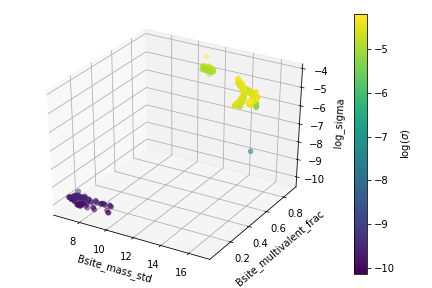

In [232]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
#f1,f2,f3 = sfs_rr.subsets_[5]['feature_names'][2:5]
f1 = 'Bsite_mass_std'
f2 = 'Bsite_multivalent_frac'
f3 = 'log_sigma'
p = ax.scatter(Xy_df[f1],Xy_df[f2],Xy_df[f3],c=Xy_df[response_col])
ax.set_xlabel(f1)
ax.set_ylabel(f2)
ax.set_zlabel(f3)

fig.colorbar(p,label='log($\sigma$)')
fig.tight_layout()

<IPython.core.display.Javascript object>


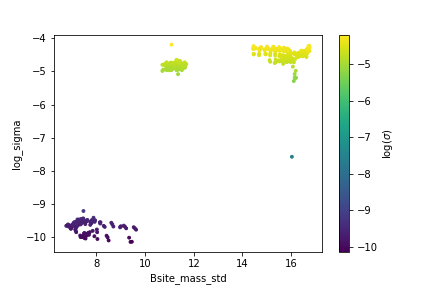

In [239]:
fig, ax = plt.subplots()
f1,f2 = sfs_rr.subsets_[2]['feature_names'][0:2]#sfs.k_feature_names_[0:2]
#f1 = 'Bsite_multivalent_frac'
#f1,f2 = ('comp_oxmax_OS_mean', 'Bsite_MX_IC_mean')
f1='Bsite_multivalent_frac'
#f2 = 'Bsite_valence_elec_s_frac'
f1 = 'Bsite_mass_std'
f2 = 'log_sigma'
#f2 = 'Bsite_oxstd_X_cat_std'
#f2 = 'Bsite_multivalent_frac'
p = ax.scatter(Xy_df[f1],Xy_df[f2],c=y,s=8)
ax.set_xlabel(f1)
ax.set_ylabel(f2)
fig.colorbar(p,label='log($\sigma$)')
#ax.set_ylim(-5.0,-4)

<IPython.core.display.Javascript object>


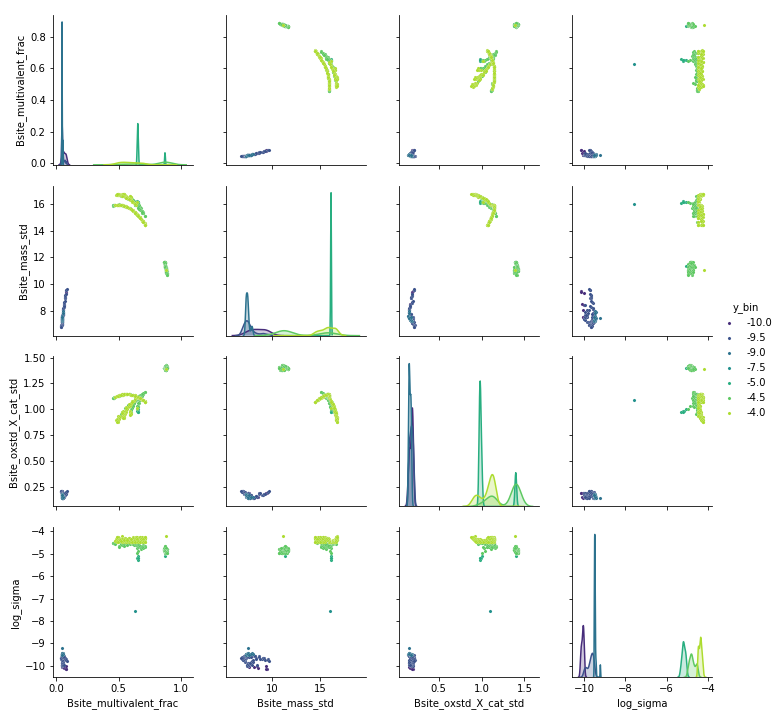

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\bandwidths.py:22: RuntimeWarning:

invalid value encountered in minimum

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce



In [198]:
sns.pairplot(Xy_df,vars=['Bsite_multivalent_frac','Bsite_mass_std','Bsite_oxstd_X_cat_std','log_sigma'],diag_kind='kde',hue='y_bin',palette='viridis',
             plot_kws={'s':10,'linewidth':0.1})

<IPython.core.display.Javascript object>


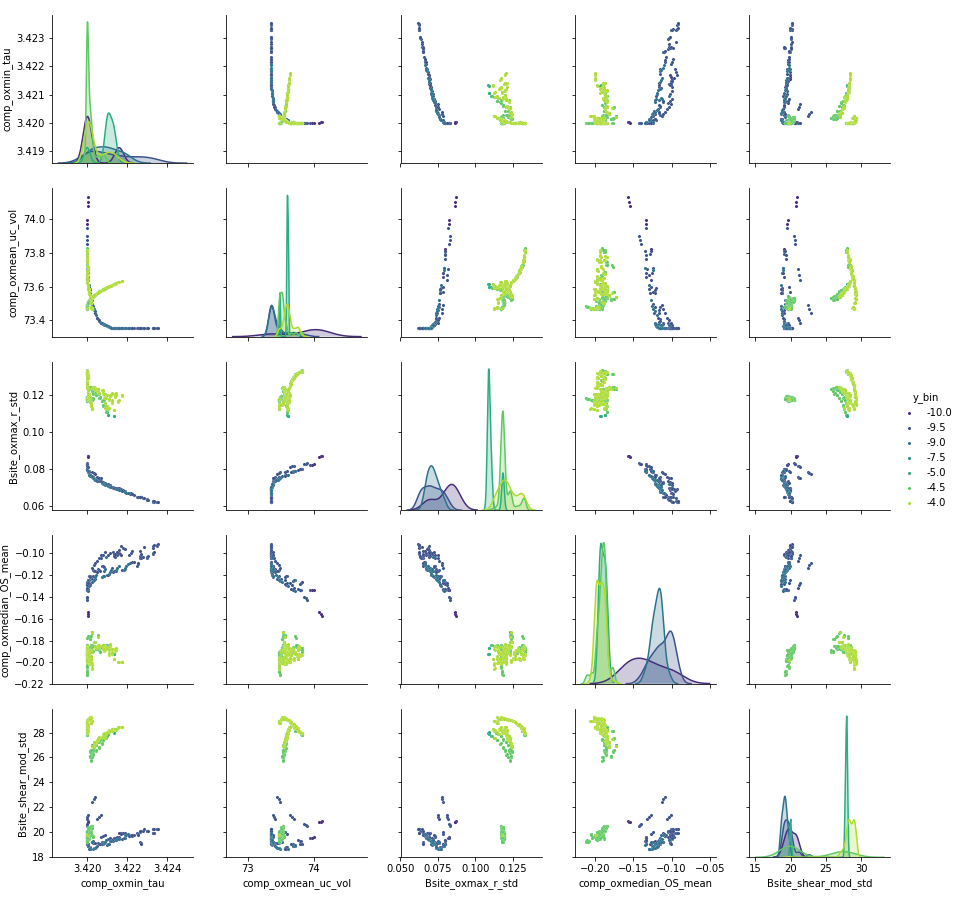

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\bandwidths.py:22: RuntimeWarning:

invalid value encountered in minimum

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce



In [229]:
sns.pairplot(Xy_df,vars=list(sfs_rr.k_feature_names_),diag_kind='kde',hue='y_bin',palette='viridis',
             plot_kws={'s':10,'linewidth':0.1})
#plt.gcf().tight_layout()

Test cluster PDAC_COM3_01251
Test cluster PDAC_COM3_01254
Test cluster PDAC_COM3_01255
Test cluster PDAC_COM3_01256
Train scores:  [0.99207116 0.99439344 0.51825892 0.98993701] 
	Mean train score:  0.873665135160353
Test scores:  [-1.97600133e+01  1.06613314e-01 -2.58728899e+02 -4.32435665e+00] 
	Mean test score:  -70.67666380333935


<IPython.core.display.Javascript object>


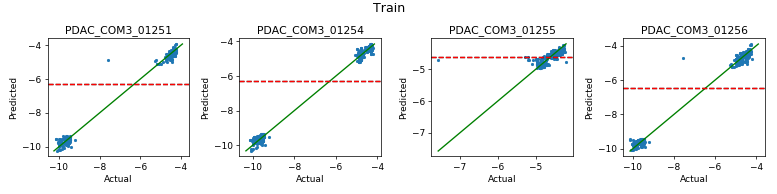

<IPython.core.display.Javascript object>


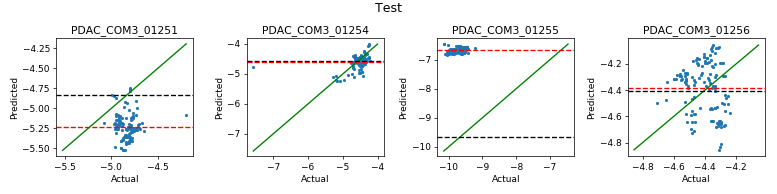

<IPython.core.display.Javascript object>


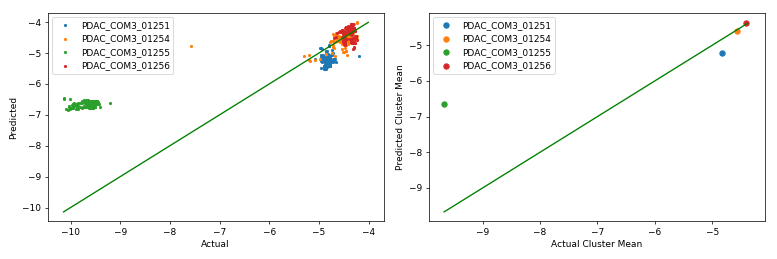

In [227]:
X_red = X_df.loc[:,sfs_rr.k_feature_names_].values
Xrs = ss.fit_transform(X_red)
mv.plot_loco_cv(Ridge,Xrs,y,clusters,ncol=4,alpha=1e-1)#e-1)

Test cluster PDAC_COM3_01251
Test cluster PDAC_COM3_01254
Test cluster PDAC_COM3_01255
Test cluster PDAC_COM3_01256
Train scores:  [0.99928452 0.99978299 0.9376119  0.9991629 ] 
	Mean train score:  0.9839605781768672
Test scores:  [-6.68386054e+00  3.31767376e-02 -3.14569892e+02 -2.78051637e-01] 
	Mean test score:  -80.3746569251218


<IPython.core.display.Javascript object>


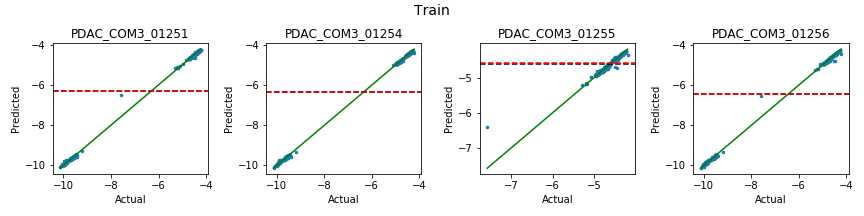

<IPython.core.display.Javascript object>


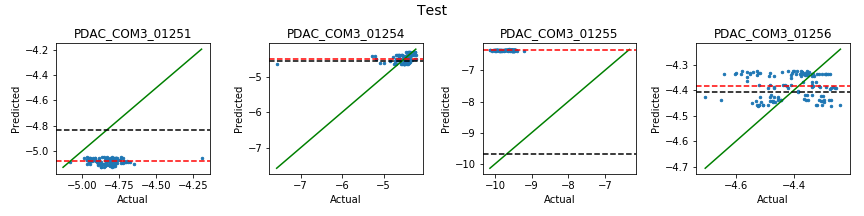

<IPython.core.display.Javascript object>


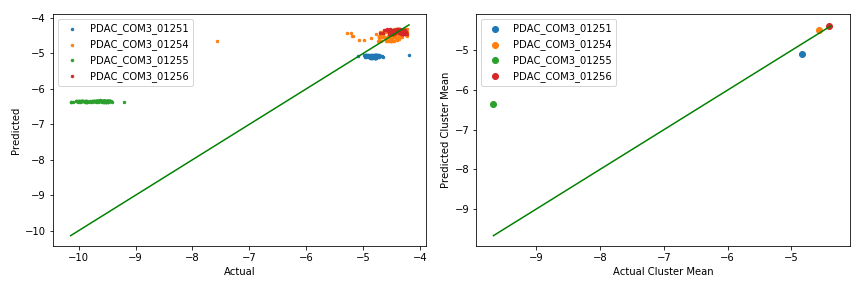

In [231]:
mv.plot_loco_cv(RandomForestRegressor,Xrs,y,clusters,ncol=4,n_estimators=100)

In [17]:
sfs.k_feature_names_

('comp_oxmin_tau',
 'comp_oxmean_alat_hardsphere',
 'Bsite_oxmax_r_std',
 'comp_oxmedian_OS_mean',
 'Bsite_shear_mod_std')

## Feature selection as part of training 
Features selected based on training fold only

Test cluster PDAC_COM3_01251


[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    2.1s finished

[2019-03-05 15:41:36] Features: 1/3 -- score: 0.972971750445044[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.6s finished

[2019-03-05 15:41:40] Features: 2/3 -- score: 0.9882723423873704[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.9s finished

[2019-03-05 15:41:44] Features: 3/3 -- score: 0.9894940809575997

Test cluster PDAC_COM3_01254


[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    2.2s finished

[2019-03-05 15:41:46] Features: 1/3 -- score: 0.9934337491916114[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    2.5s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.6s finished

[2019-03-05 15:41:51] Features: 2/3 -- score: 0.9941135167722194[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:    4.8s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.9s finished

[2019-03-05 15:41:57] Features: 3/3 -- score: 0.9946122274190373

Test cluster PDAC_COM3_01255


[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    2.1s finished

[2019-03-05 15:42:00] Features: 1/3 -- score: 0.5626697011843095[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.6s finished

[2019-03-05 15:42:04] Features: 2/3 -- score: 0.6094934171691513[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.9s finished

[2019-03-05 15:42:08] Features: 3/3 -- score: 0.6300562429584823

Test cluster PDAC_COM3_01256


[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    2.1s finished

[2019-03-05 15:42:11] Features: 1/3 -- score: 0.9556200751611099[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.6s finished

[2019-03-05 15:42:14] Features: 2/3 -- score: 0.9770486321965809[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.9s finished

[2019-03-05 15:42:19] Features: 3/3 -- score: 0.986416727884695

Train scores:  [0.99025825 0.99508299 0.5397458  0.98820859] 
	Mean train score:  0.8783239067154831
Test scores:  [-212.69691031  -13.7043946  -810.52656024 -166.9014825 ] 
	Mean test score:  -300.95733691006734


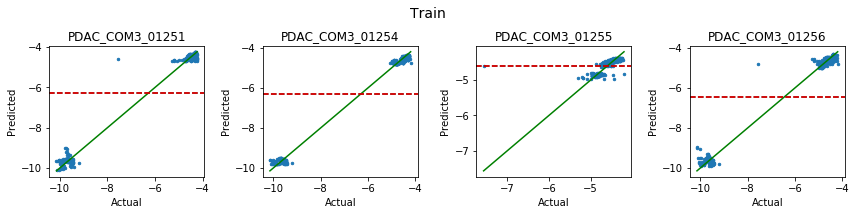

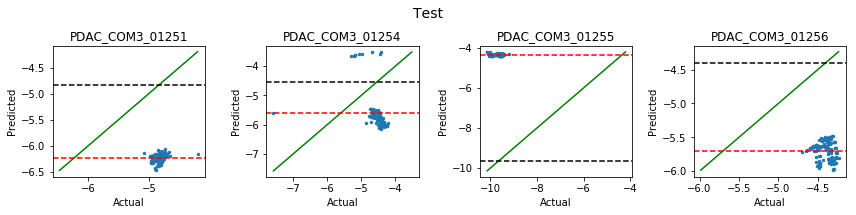

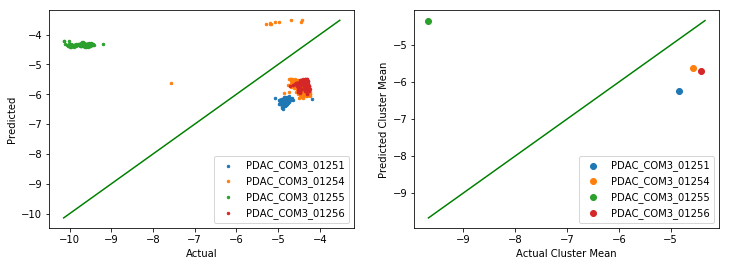

In [117]:
"Simply run feature selection as part of training process"
rr_sfs = Ridge(alpha=10)
#rr = KernelRidge(alpha=1,kernel='laplacian',degree=3)

select = SFS(rr_sfs,
          k_features=3,
          forward=True,
          floating=True,
          verbose=2,
          scoring='r2',
          cv=KFold(3,shuffle=True),
          n_jobs=4
)

rr_fit = Ridge(alpha=1)
sel_ridge = Pipeline([('feature_select',select),
                           ('ridge',rr_fit)])


mv.plot_loco_cv(sel_ridge,Xs,y,clusters,ncol=4,standardize=False)

Test set: PDAC_COM3_01251
---------------------------
Selecting features for PDAC_COM3_01254
Selecting features for PDAC_COM3_01255
Selecting features for PDAC_COM3_01256
Selecting features for full train set
Selected superset: ['Bsite_oxmax_ion_energy_mean', 'comp_LUMO_energy', 'comp_space_group_std', 'comp_oxmin_goldschmidt', 'comp_num_atoms', 'comp_oxrange_ion_energy_std', 'Bsite_oxmean_ion_energy_mean', 'comp_X_mean', 'comp_oxmean_r_std', 'comp_oxmedian_X_cat_mean', 'comp_space_group_mean', 'Bsite_oxmax_tot_charge', 'comp_oxmin_uc_vol_free', 'comp_oxmean_alat_hardsphere', 'comp_oxmedian_uc_vol', 'comp_polarizability_std', 'Bsite_oxstd_OS_std', 'comp_HOMO_energy']
Final feature selection
Final features: ('comp_space_group_std', 'comp_oxrange_ion_energy_std', 'comp_oxmedian_uc_vol', 'comp_polarizability_std', 'Bsite_oxstd_OS_std')
Test set: PDAC_COM3_01254
---------------------------
Selecting features for PDAC_COM3_01251
Selecting features for PDAC_COM3_01255
Selecting features for 

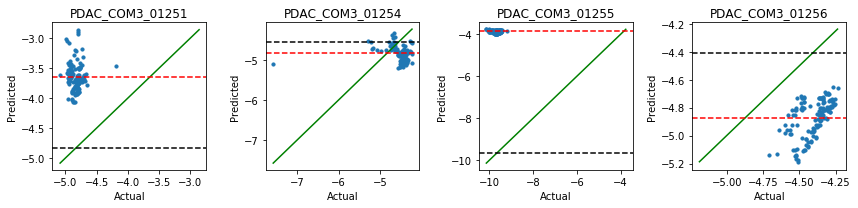

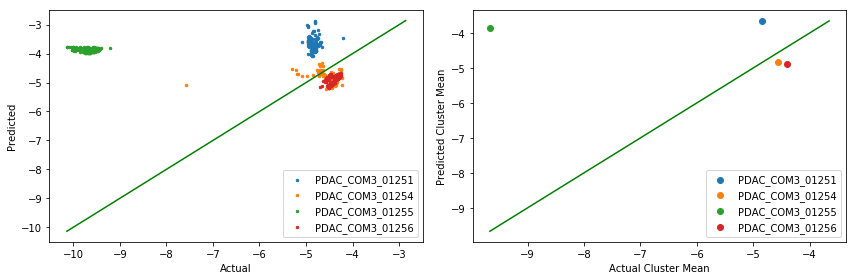

In [118]:
"""
More complex feature selection for each fold
Training process (for each fold):
    Run feature selection to identify n_feat features for each individual cluster in training data
    Run feature selection to identify n_feat features for full training set
    Concatenate all identified features into a superset of possible features
    Run feature selection on full training set using only the features in the superset from above
    Train the model with final selected features
"""
#class FeatureSelectingRidge(n_feat,select_ridge_params,fit_ridge_params,standardize=False):
    
standardize=True
rr_fs = Ridge(alpha=10)
n_feat = 5

select = SFS(rr_fs,
          k_features=n_feat,
          forward=True,
          floating=True,
          verbose=0,
          scoring='r2',
          cv=KFold(3,shuffle=True),
          n_jobs=4
)

rr_fit = Ridge(alpha=10)
sel_ridge = Pipeline([('feature_select',select),
                           ('ridge',rr_fit)])


df = X_df


"later, move this within the training loop. Fit the scaler to train data only and use the fit to transform the test data"
if standardize==True:
    ss = StandardScaler()
    X = ss.fit_transform(X_df)
else:
    X = X_df.values
estimator = sel_ridge


unique_clusters = list(np.unique(clusters))
fig, axes = plt.subplots(1,4,figsize=(12,3))

act_means = []
pred_means = []
test_act = []
test_pred = []
for ax,test_cluster in zip(axes.ravel(),unique_clusters):
    print(f'Test set: {test_cluster}\n---------------------------')
    #test_cluster = 'PDAC_COM3_01251'

    train_clusters = unique_clusters.copy()
    train_clusters.remove(test_cluster)

    #run feature selection for each cluster
    train_features = []
    for cluster in train_clusters:
        print(f'Selecting features for {cluster}')
        idx = np.where(clusters==cluster)
        Xc = X[idx]
        yc = y[idx]
        select.fit(Xc,yc,custom_feature_names=X_df.columns.values)
        #print(select.subsets_[n_feat])
        train_features.append(list(select.k_feature_names_))

    #run feature selection for all clusters
    print('Selecting features for full train set')
    train_idx = np.where(clusters!=test_cluster)
    Xc = X[idx]
    yc = y[idx]
    select.fit(Xc,yc,custom_feature_names=X_df.columns.values)
    train_features.append(list(select.k_feature_names_))

    #get all selected features
    selected_features = list(set(sum(train_features,[])))
    #print('Train features:', train_features)
    print('Selected superset:', selected_features)
    X_select = X_df.loc[:,selected_features].values
    if standardize==True:
        X_select = ss.fit_transform(X_select)          

    #partition train and test data

    X_train = X_select[train_idx]
    y_train= y[train_idx]
    test_idx = np.where(clusters==test_cluster)
    X_test = X_select[test_idx]
    y_test = y[test_idx]

    #test model
    print('Final feature selection')
    estimator.fit(X_train,y_train,feature_select__custom_feature_names=selected_features)
    print('Final features:', estimator.named_steps['feature_select'].k_feature_names_)
    mv.plot_pva(estimator,X_test,y_test,ax=ax)
    ax.set_title(test_cluster)
    ax.axhline(np.mean(y_test),c='k',ls='--')
    ax.axhline(np.mean(estimator.predict(X_test)),c='r',ls='--')

    act_means.append(np.mean(y_test))
    pred_means.append(np.mean(estimator.predict(X_test)))
    test_act.append(y_test)
    test_pred.append(estimator.predict(X_test))
    # train_pred.append(estimator.predict(X_train))
    # train_act.append(y_train)
    # test_pred.append(estimator.predict(X_test))
    # test_act.append(y_test)
    # train_scores[i] = estimator.score(X_train,y_train)
    # test_scores[i] = estimator.score(X_test,y_test)
    
# fig3, ax3 = plt.subplots()
# for cluster, act, pred in zip(unique_clusters,act_means,pred_means):
#     ax3.scatter(act,pred,label=cluster)
# ax3.legend()
# ax3.set_xlabel('Actual Cluster Mean')
# ax3.set_ylabel('Predicted Cluster Mean')
# axmin = mv.multi_min((act_means,pred_means))
# axmax = mv.multi_max((act_means,pred_means))
# ax3.plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')
# ax3.legend(loc='upper left',bbox_to_anchor=(1,1))

# fig.tight_layout()
# fig3.tight_layout()


fig3, axes3 = plt.subplots(1,2,figsize=(12,4))
#(a) all test points
for cluster, act, pred in zip(unique_clusters,test_act,test_pred):
    axes3[0].scatter(act,pred,label=cluster,s=6)
axes3[0].legend()
axes3[0].set_xlabel('Actual')
axes3[0].set_ylabel('Predicted')
axmin = mv.multi_min((mv.multi_min(test_act),mv.multi_min(test_pred)))
axmax = mv.multi_max((mv.multi_max(test_act),mv.multi_max(test_pred)))
axes3[0].plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')

#(b) cluster means
for cluster, act, pred in zip(unique_clusters,act_means,pred_means):
    axes3[1].scatter(act,pred,label=cluster)
axes3[1].legend()
axes3[1].set_xlabel('Actual Cluster Mean')
axes3[1].set_ylabel('Predicted Cluster Mean')
axmin = mv.multi_min((act_means,pred_means))
axmax = mv.multi_max((act_means,pred_means))
axes3[1].plot([axmin,axmax],[axmin,axmax],'g-',label='Ideal')

fig.tight_layout()
fig3.tight_layout()

In [20]:
X_df.columns.values[list(sel_ridge.steps[0][1].k_feature_idx_)]

array(['comp_oxmin_goldschmidt', 'comp_oxmax_goldschmidt_struct',
       'comp_oxmax_anion_delta', 'comp_oxmax_alat_hardsphere',
       'comp_oxmean_goldschmidt'], dtype=object)

### Run LOCO-CV feature selection as part of training process

Test set: PDAC_COM3_01251


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    9.2s finished

[2019-03-05 15:53:58] Features: 1/5 -- score: -170.4148186599596[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    9.3s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.3s finished

[2019-03-05 15:54:10] Features: 2/5 -- score: -152.92914199206936[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:    9.8s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.5s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.4s finished

[2019-03-05 15:54:29] Features: 2/5 -- score: -40.39556180881066[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 158 out of 332 | elapsed:    9.2s remaining:   10.1s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:    9.5s

Test set: PDAC_COM3_01254


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    9.5s finished

[2019-03-05 15:55:32] Features: 1/5 -- score: -188.98666302447646[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    9.6s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.4s finished

[2019-03-05 15:55:46] Features: 2/5 -- score: -152.41061262352147[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   11.1s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.6s finished

[2019-03-05 15:56:02] Features: 3/5 -- score: -133.59477620478467[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    6.8s finished

[2019-03-05 15:56:21] Features: 4/5 -- score: -126.77502579795811[P

Test set: PDAC_COM3_01255


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    9.2s finished

[2019-03-05 15:56:51] Features: 1/5 -- score: -0.1996859020354553[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   10.5s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.5s finished

[2019-03-05 15:57:05] Features: 2/5 -- score: 0.09333675771410128[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:    9.9s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.5s finished

[2019-03-05 15:57:20] Features: 3/5 -- score: 0.09426926966603189[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    7.1s finished

[2019-03-05 15:57:40] Features: 4/5 -- score: 0.09477968695935717[P

Test set: PDAC_COM3_01256


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    9.7s finished

[2019-03-05 15:58:11] Features: 1/5 -- score: -149.87221127024583[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   11.8s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.3s finished

[2019-03-05 15:58:26] Features: 2/5 -- score: -115.79935400340332[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   10.0s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.7s finished

[2019-03-05 15:58:42] Features: 3/5 -- score: -114.47158283114935[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:    9.3s finished
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    6.4s finished

[2019-03-05 15:58:59] Features: 4/5 -- score: -113.67005000832434[P

Train scores:  [0.98713729 0.98628785 0.48485542 0.97761535] 
	Mean train score:  0.8589739786006697
Test scores:  [ -43.62903966   -8.14544884 -710.56976307 -304.02989598] 
	Mean test score:  -266.59353688764855
Selected features:
PDAC_COM3_01251 ['comp_oxmin_goldschmidt_struct', 'comp_oxmedian_goldschmidt_struct', 'Bsite_oxmedian_ion_energy_std', 'Bsite_mass_std', 'comp_melt_temp_mean']
PDAC_COM3_01254 ['comp_oxmax_uc_vol', 'comp_oxmedian_goldschmidt_struct', 'comp_oxstd_uc_vol', 'comp_oxrange_uc_vol', 'comp_oxstd_MX_ABE']
PDAC_COM3_01255 ['comp_oxmedian_tau', 'Bsite_oxmax_OS_std', 'Bsite_oxmax_X_cat_std', 'comp_mass_mean', 'Bsite_polarizability_std']
PDAC_COM3_01256 ['comp_oxmean_uc_vol_free', 'comp_oxmedian_goldschmidt_struct', 'Bsite_oxmean_ion_energy_std', 'comp_mass_mean', 'comp_polarizability_mean']


{'PDAC_COM3_01251': ['comp_oxmin_goldschmidt_struct',
  'comp_oxmedian_goldschmidt_struct',
  'Bsite_oxmedian_ion_energy_std',
  'Bsite_mass_std',
  'comp_melt_temp_mean'],
 'PDAC_COM3_01254': ['comp_oxmax_uc_vol',
  'comp_oxmedian_goldschmidt_struct',
  'comp_oxstd_uc_vol',
  'comp_oxrange_uc_vol',
  'comp_oxstd_MX_ABE'],
 'PDAC_COM3_01255': ['comp_oxmedian_tau',
  'Bsite_oxmax_OS_std',
  'Bsite_oxmax_X_cat_std',
  'comp_mass_mean',
  'Bsite_polarizability_std'],
 'PDAC_COM3_01256': ['comp_oxmean_uc_vol_free',
  'comp_oxmedian_goldschmidt_struct',
  'Bsite_oxmean_ion_energy_std',
  'comp_mass_mean',
  'comp_polarizability_mean']}

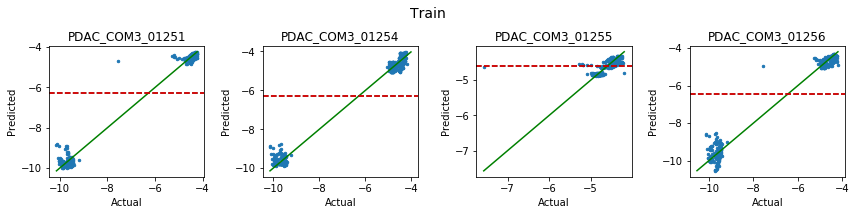

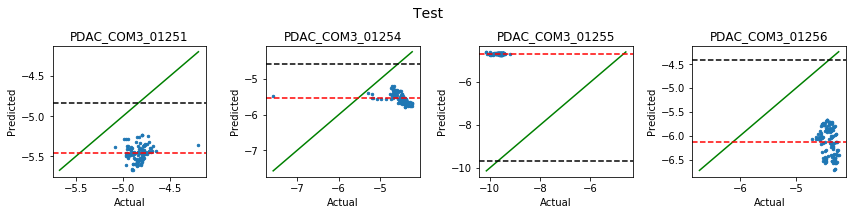

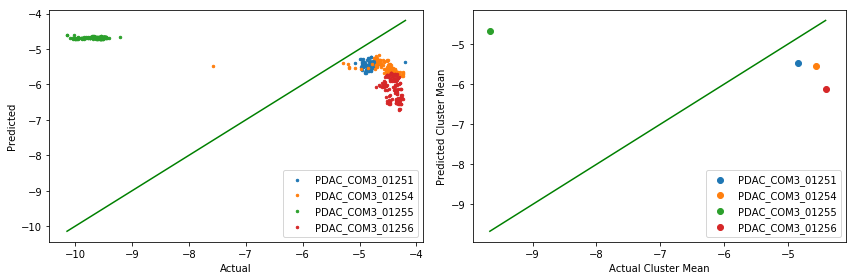

In [119]:
cv_est = Ridge(alpha=10)
select_est = Ridge(alpha=10)
k_features = 5

mv.plot_loco_cv_with_selection(cv_est, select_est,X_df,y,clusters,k_features,mv.LeaveOneClusterOut,
                         forward=True,
                          floating=True,
                          verbose=2,
                          scoring='r2',
                          n_jobs=4)

Test set: PDAC_COM3_01251


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   12.7s finished

[2019-03-04 22:23:23] Features: 1/5 -- score: -27.946309238296354[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   11.7s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.3s finished

[2019-03-04 22:23:38] Features: 2/5 -- score: -5.911117287085394[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   14.0s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.6s finished

[2019-03-04 22:23:58] Features: 3/5 -- score: -5.627050834352723[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done 256 tasks      | elapsed:   14.4s
[Parallel(n_jobs=4)]: Done 324 out of 331 | elapsed:   16.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:   16.2s finished

Test set: PDAC_COM3_01254


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   12.3s finished

[2019-03-04 22:26:03] Features: 1/5 -- score: -170.31165629573792[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   18.5s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.3s finished

[2019-03-04 22:26:25] Features: 2/5 -- score: -24.90797598530094[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   17.6s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.4s finished

[2019-03-04 22:26:48] Features: 3/5 -- score: -11.702605450254161[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done

Test set: PDAC_COM3_01255


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   11.9s finished

[2019-03-04 22:27:54] Features: 1/5 -- score: -0.4082807580188353[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 326 out of 333 | elapsed:   15.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   15.7s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.3s finished

[2019-03-04 22:28:13] Features: 2/5 -- score: -0.2770931021503204[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   13.8s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.3s finished

[2019-03-04 22:28:32] Features: 3/5 -- score: -0.2758790553966201[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    6.

Test set: PDAC_COM3_01256


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   14.4s finished

[2019-03-04 22:30:01] Features: 1/5 -- score: -189.9300862236304[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   12.0s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.3s finished

[2019-03-04 22:30:16] Features: 2/5 -- score: -131.5961391708053[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done 268 tasks      | elapsed:   14.4s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   15.7s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.4s finished

[2019-03-04 22:30:38] Features: 3/5 -- score: -101.4492604184062[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:   14.5s finished
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(

Train scores:  [0.99213192 0.99621289 0.49743276 0.99021658] 
	Mean train score:  0.8689985348006442
Test scores:  [-1.09645855e+05 -2.11750850e+00 -9.34509114e+02 -2.81462285e+02] 
	Mean test score:  -27715.985897513205


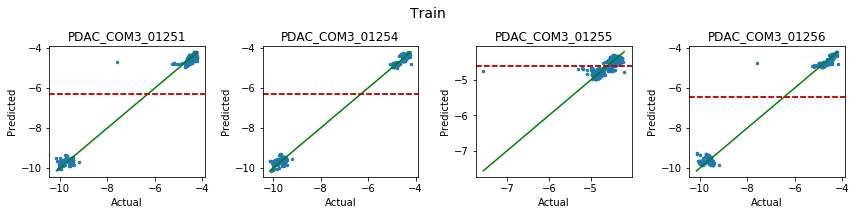

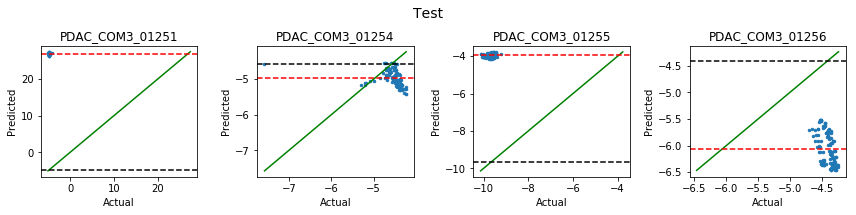

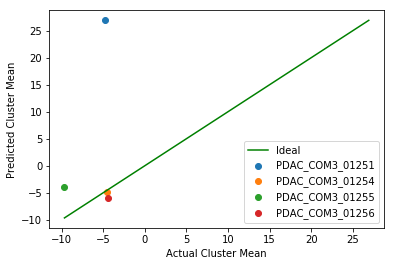

In [24]:
cv_est = KernelRidge(kernel='poly',degree=3,alpha=10)
select_est = KernelRidge(kernel='poly',degree=3,alpha=10)
k_features = 5

mv.plot_loco_cv_with_selection(cv_est, select_est,X_df,y,clusters,k_features,mv.LeaveOneClusterOut,
                         forward=True,
                          floating=True,
                          verbose=2,
                          scoring='r2',
                          n_jobs=4)

Test set: PDAC_COM3_01251


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 269 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 327 out of 334 | elapsed:   13.8s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   13.9s finished

[2019-03-04 22:32:04] Features: 1/5 -- score: -42.5833713063263[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 267 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.2s finished

[2019-03-04 22:32:22] Features: 2/5 -- score: -31.970782208259703[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 254 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   16.0s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.3s finished

[2019-03-04 22:32:43] Features: 3/5 -- score: -31.070723017213698[Paralle

Test set: PDAC_COM3_01254


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 269 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 327 out of 334 | elapsed:   14.3s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   14.4s finished

[2019-03-04 22:33:46] Features: 1/5 -- score: -226.15154761159235[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 264 tasks      | elapsed:   13.9s
[Parallel(n_jobs=4)]: Done 326 out of 333 | elapsed:   15.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   15.3s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.4s finished

[2019-03-04 22:34:05] Features: 2/5 -- score: -216.96592203375576[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 263 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 325 out of 332 | elapsed:   15.3s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:

Test set: PDAC_COM3_01255


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 269 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 327 out of 334 | elapsed:   13.8s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   14.0s finished

[2019-03-04 22:35:30] Features: 1/5 -- score: -0.26344213309114095[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 267 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.2s finished

[2019-03-04 22:35:48] Features: 2/5 -- score: -0.03707623560263932[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 263 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 325 out of 332 | elapsed:   15.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   15.6s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.5s

Test set: PDAC_COM3_01256


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 269 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 327 out of 334 | elapsed:   14.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   14.2s finished

[2019-03-04 22:37:12] Features: 1/5 -- score: -47.11114460884108[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 266 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done 326 out of 333 | elapsed:   15.0s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.3s finished

[2019-03-04 22:37:30] Features: 2/5 -- score: -34.382619009350535[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 264 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   15.7s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.3s fi

Train scores:  [0.99994965 0.99995866 0.99766194 0.99998044] 
	Mean train score:  0.999387670295189
Test scores:  [  -6.66422295   -3.1780931  -737.67823365  -17.27825928] 
	Mean test score:  -191.19970224454943


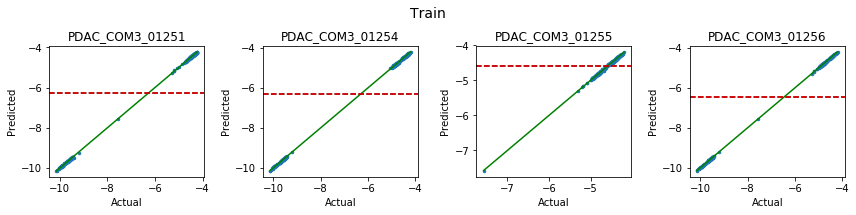

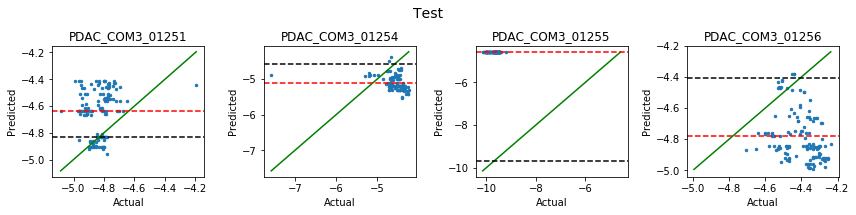

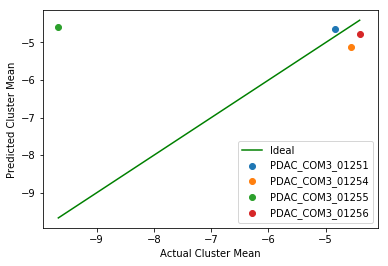

In [25]:
cv_est = GradientBoostingRegressor(learning_rate=0.5)
select_est = GradientBoostingRegressor(learning_rate=0.5)
k_features = 5

mv.plot_loco_cv_with_selection(cv_est, select_est,X_df,y,clusters,k_features,mv.LeaveOneClusterOut,
                         forward=True,
                          floating=True,
                          verbose=2,
                          scoring='r2',
                          n_jobs=4)

Test set: PDAC_COM3_01251


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   45.9s finished

[2019-03-04 22:39:29] Features: 1/5 -- score: -86.5898930085175[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   27.2s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   49.0s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.5s finished

[2019-03-04 22:40:22] Features: 2/5 -- score: -69.75073025127124[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   51.7s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.6s finished

[2019-03-04 22:41:19] Features: 3/5 -- score: -66.5405225796084[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done 154

Test set: PDAC_COM3_01254


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   45.7s finished

[2019-03-04 22:44:14] Features: 1/5 -- score: -226.60667306199323[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   27.8s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   49.8s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.6s finished

[2019-03-04 22:45:07] Features: 2/5 -- score: -226.17362728443473[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   27.5s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   49.3s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.7s finished

[2019-03-04 22:46:02] Features: 3/5 -- score: -226.13991047341844[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Don

Test set: PDAC_COM3_01255


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   25.9s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   45.2s finished

[2019-03-04 22:48:44] Features: 1/5 -- score: -0.3099811052066325[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   27.7s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   49.6s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.6s finished

[2019-03-04 22:49:37] Features: 2/5 -- score: 0.03986069481718513[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   52.2s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.6s finished

[2019-03-04 22:50:35] Features: 3/5 -- score: 0.10441138721945564[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Don

Test set: PDAC_COM3_01256


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   25.7s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   45.0s finished

[2019-03-04 22:53:21] Features: 1/5 -- score: -92.53872365609051[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   27.8s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   49.5s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.6s finished

[2019-03-04 22:54:14] Features: 2/5 -- score: -80.91194843236006[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   28.9s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   52.0s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.6s finished

[2019-03-04 22:55:12] Features: 3/5 -- score: -80.12046375542106[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 1

Train scores:  [0.99925432 0.99910411 0.94344295 0.99927733] 
	Mean train score:  0.9852696776490091
Test scores:  [ -13.49318752   -0.79726343 -489.65970631  -20.92569127] 
	Mean test score:  -131.21896213167722


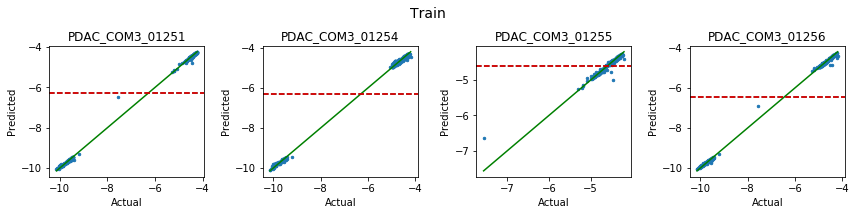

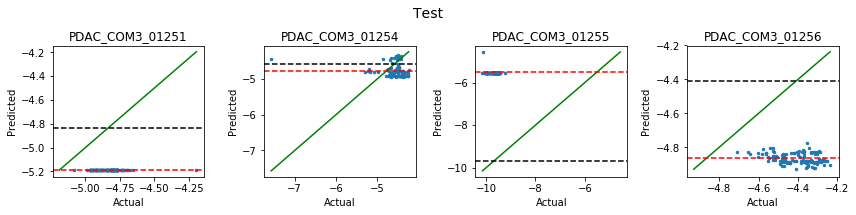

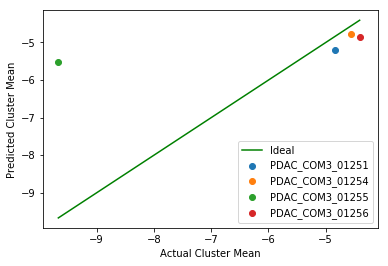

In [26]:
cv_est = RandomForestRegressor(n_estimators=100)
select_est = RandomForestRegressor(n_estimators=100)
k_features = 5

mv.plot_loco_cv_with_selection(cv_est, select_est,X_df,y,clusters,k_features,mv.LeaveOneClusterOut,
                         forward=True,
                          floating=True,
                          verbose=2,
                          scoring='r2',
                          n_jobs=4)

Test set: PDAC_COM3_01251


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   41.0s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:  1.0min finished

[2019-03-05 08:22:41] Features: 1/8 -- score: -84.49982033016973[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   28.3s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   50.4s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.5s finished

[2019-03-05 08:23:35] Features: 2/8 -- score: -75.2874254398301[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   29.2s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   52.4s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.8s finished

[2019-03-05 08:24:33] Features: 3/8 -- score: -79.40297688758159[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done 15

Test set: PDAC_COM3_01254


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   46.3s finished

[2019-03-05 08:32:19] Features: 1/8 -- score: -226.30898932586942[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   28.3s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   50.5s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.6s finished

[2019-03-05 08:33:13] Features: 2/8 -- score: -226.12986251759767[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   27.6s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   49.8s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.7s finished

[2019-03-05 08:34:08] Features: 3/8 -- score: -226.1880273216378[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done

Test set: PDAC_COM3_01255


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   26.6s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   46.9s finished

[2019-03-05 08:39:56] Features: 1/8 -- score: -0.27364971554498874[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   27.4s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   49.6s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.7s finished

[2019-03-05 08:40:49] Features: 2/8 -- score: 0.06377407811065712[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   29.3s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   52.9s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.8s finished

[2019-03-05 08:41:48] Features: 3/8 -- score: 0.11775268961360863[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Do

Test set: PDAC_COM3_01256


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   25.9s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   45.9s finished

[2019-03-05 08:50:26] Features: 1/8 -- score: -73.70950191442759[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   27.6s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   49.3s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.9s finished

[2019-03-05 08:51:19] Features: 2/8 -- score: -84.48247828076983[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   28.7s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   52.1s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.7s finished

[2019-03-05 08:52:17] Features: 3/8 -- score: -81.29156967479072[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 1

Train scores:  [0.99925258 0.99906253 0.93844365 0.99875534] 
	Mean train score:  0.9838785240376475
Test scores:  [  -1.31959342   -0.82196046 -578.05599754   -6.40239732] 
	Mean test score:  -146.6499871844637


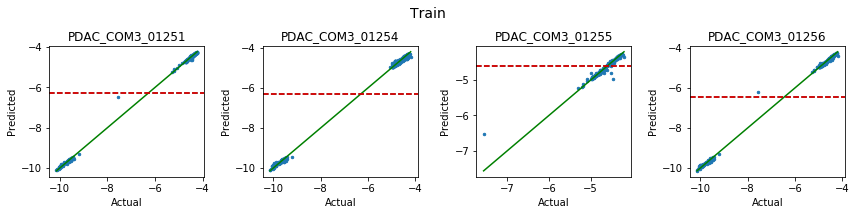

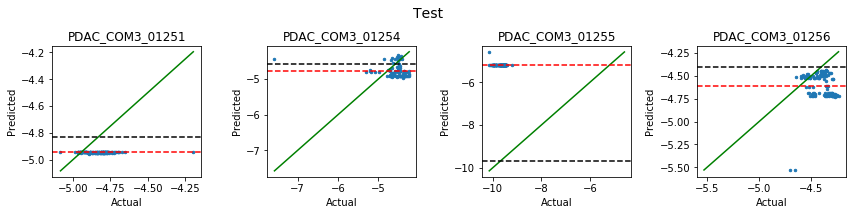

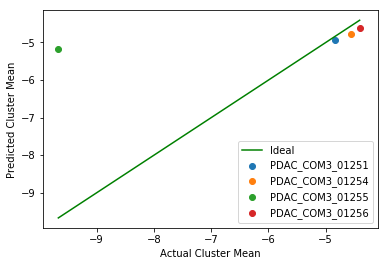

In [27]:
cv_est = RandomForestRegressor(n_estimators=100)
select_est = RandomForestRegressor(n_estimators=100)
k_features = 8

mv.plot_loco_cv_with_selection(cv_est, select_est,X_df,y,clusters,k_features,mv.LeaveOneClusterOut,
                         forward=True,
                          floating=True,
                          verbose=2,
                          scoring='r2',
                          n_jobs=4)

In [ ]:
# cv_est = SVR(kernel='poly', degree=2, C=50, epsilon=0.05)
# select_est = SVR(kernel='poly', degree=2, C=50, epsilon=0.05)
# k_features = 5

# mv.plot_loco_cv_with_selection(cv_est, select_est,X_df,y,clusters,k_features,mv.LeaveOneClusterOut,
#                          forward=True,
#                           floating=True,
#                           verbose=2,
#                           scoring='r2',
#                           n_jobs=4)

### Use thickness

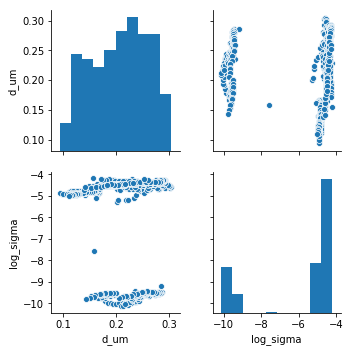

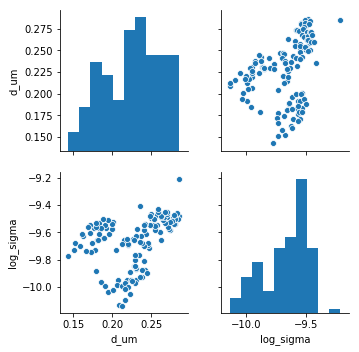

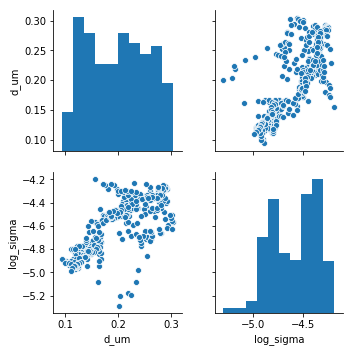

In [38]:
low = dc.clean_data[dc.clean_data['sample']=='PDAC_COM3_01255']
high = dc.clean_data[(dc.clean_data['sample']!='PDAC_COM3_01255') & (dc.clean_data['log_sigma']>-7)]
sns.pairplot(dc.clean_data,vars=['d_um','log_sigma'])
sns.pairplot(low,vars=['d_um','log_sigma'])
sns.pairplot(high,vars=['d_um','log_sigma'])

In [48]:
#add thickness to inputs
Xd_df = X_df.copy()
Xd_df.insert(X_df.shape[1],'thickness',dc.clean_data['d_um'])
Xd_df.head()

,comp_oxmin_goldschmidt,comp_oxmin_goldschmidt_struct,comp_oxmin_tau,comp_oxmin_tot_cat_charge,comp_oxmin_anion_delta,comp_oxmin_alat_hardsphere,comp_oxmin_uc_vol,comp_oxmin_uc_vol_free,comp_oxmin_r_crit,comp_oxmax_goldschmidt,...,comp_valence_unfilled_f_mean,comp_valence_unfilled_f_std,comp_valence_unfilled_f_range,comp_polarizability_mean,comp_polarizability_std,comp_polarizability_range,comp_sigma_therm_mean,comp_sigma_therm_std,comp_sigma_therm_range,thickness
1_500C_dry_1251,0.992770,2.0,3.420198,4.199360,0.03339,4.186072,73.353379,24.475398,0.886408,1.083702,...,0.0,0.0,0.0,10.085616,19.683882,38.898,19.680210,43.338016,99.97342,0.112290
2_500C_dry_1251,0.992760,2.0,3.420200,4.201362,0.03238,4.186072,73.353379,24.464849,0.886424,1.083683,...,0.0,0.0,0.0,10.091678,19.688179,38.898,19.677289,43.323369,99.97342,0.114887
3_500C_dry_1251,0.992749,2.0,3.420202,4.203340,0.03139,4.186072,73.353379,24.454493,0.886440,1.083663,...,0.0,0.0,0.0,10.097750,19.692388,38.898,19.674496,43.308683,99.97342,0.117484
4_500C_dry_1251,0.992785,2.0,3.420195,4.177100,0.03234,4.186072,73.353379,24.476583,0.886387,1.085298,...,0.0,0.0,0.0,10.064643,19.686528,38.898,19.907178,43.756259,99.97342,0.119250
5_500C_dry_1251,0.992809,2.0,3.420190,4.180578,0.03215,4.186072,73.353379,24.473465,0.886352,1.085143,...,0.0,0.0,0.0,10.069012,19.687442,38.898,19.884647,43.717985,99.97342,0.122203


Test set: PDAC_COM3_01251


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   28.1s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:   50.3s finished

[2019-03-05 11:51:35] Features: 1/5 -- score: -84.77474702520401[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   54.2s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    3.1s finished

[2019-03-05 11:52:33] Features: 2/5 -- score: -76.29577271636389[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   31.1s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   55.9s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    5.2s finished

[2019-03-05 11:53:35] Features: 3/5 -- score: -77.00602913119276[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done 1

Test set: PDAC_COM3_01254


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   28.5s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:   50.5s finished

[2019-03-05 11:56:47] Features: 1/5 -- score: -226.49691147863848[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   30.2s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   54.6s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.9s finished

[2019-03-05 11:57:46] Features: 2/5 -- score: -226.01403688521052[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   29.4s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   53.2s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    5.0s finished

[2019-03-05 11:58:45] Features: 3/5 -- score: -226.16287505211895[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Don

Test set: PDAC_COM3_01255


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:   50.5s finished

[2019-03-05 12:01:44] Features: 1/5 -- score: -0.28799592116202327[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   29.0s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   52.0s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.7s finished

[2019-03-05 12:02:40] Features: 2/5 -- score: 0.08656032339646795[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   55.5s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    5.0s finished

[2019-03-05 12:03:41] Features: 3/5 -- score: 0.11649127420016869[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Do

Test set: PDAC_COM3_01256


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   29.1s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:   50.8s finished

[2019-03-05 12:08:00] Features: 1/5 -- score: -98.78126027773264[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   51.0s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.8s finished

[2019-03-05 12:08:55] Features: 2/5 -- score: -81.02030132211873[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   30.6s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   55.7s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.9s finished

[2019-03-05 12:09:57] Features: 3/5 -- score: -71.85271840631745[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 1

Train scores:  [0.99906056 0.99900172 0.90634929 0.99897695] 
	Mean train score:  0.9758471286582743
Test scores:  [  -1.82179627   -0.82192287 -607.139002   -487.2768382 ] 
	Mean test score:  -274.26488983650034
Selected features:
PDAC_COM3_01251 ['comp_oxmean_tot_cat_charge', 'comp_oxmedian_anion_delta', 'comp_oxrange_alat_hardsphere', 'Bsite_oxrange_OS_std', 'comp_oxmax_tot_charge']
PDAC_COM3_01254 ['comp_oxmedian_ion_energy_mean', 'comp_donor_mag', 'Bsite_valence_unfilled_s_mean', 'comp_valence_elec_s_mean', 'comp_sigma_therm_range']
PDAC_COM3_01255 ['comp_oxmedian_alat_hardsphere', 'Bsite_oxmax_OS_std', 'comp_oxmedian_r_mean', 'comp_mass_std', 'Bsite_column_range']
PDAC_COM3_01256 ['comp_oxmin_r_crit', 'comp_oxstd_goldschmidt_struct', 'Bsite_oxmean_ion_energy_mean', 'Bsite_oxmedian_X_cat_std', 'comp_H_vap_range']


{'PDAC_COM3_01251': ['comp_oxmean_tot_cat_charge',
  'comp_oxmedian_anion_delta',
  'comp_oxrange_alat_hardsphere',
  'Bsite_oxrange_OS_std',
  'comp_oxmax_tot_charge'],
 'PDAC_COM3_01254': ['comp_oxmedian_ion_energy_mean',
  'comp_donor_mag',
  'Bsite_valence_unfilled_s_mean',
  'comp_valence_elec_s_mean',
  'comp_sigma_therm_range'],
 'PDAC_COM3_01255': ['comp_oxmedian_alat_hardsphere',
  'Bsite_oxmax_OS_std',
  'comp_oxmedian_r_mean',
  'comp_mass_std',
  'Bsite_column_range'],
 'PDAC_COM3_01256': ['comp_oxmin_r_crit',
  'comp_oxstd_goldschmidt_struct',
  'Bsite_oxmean_ion_energy_mean',
  'Bsite_oxmedian_X_cat_std',
  'comp_H_vap_range']}

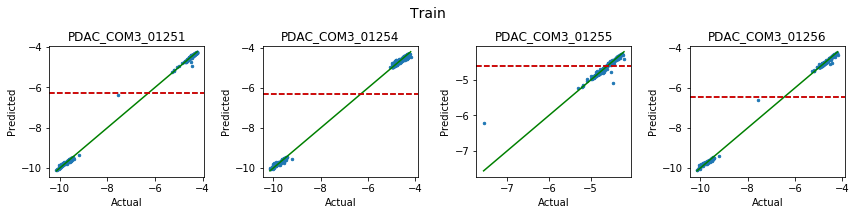

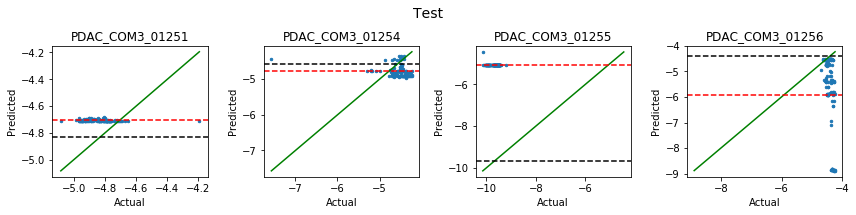

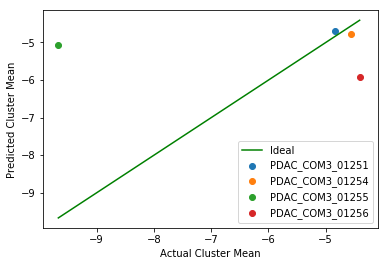

In [45]:
cv_est = RandomForestRegressor(n_estimators=100)
select_est = RandomForestRegressor(n_estimators=100)
k_features = 5

mv.plot_loco_cv_with_selection(cv_est, select_est,Xd_df,y,clusters,k_features,mv.LeaveOneClusterOut,standardize=True,
                         forward=True,
                          floating=True,
                          verbose=2,
                          scoring='r2',
                          n_jobs=4)

Test set: PDAC_COM3_01251


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   26.8s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:   46.5s finished

[2019-03-05 12:12:58] Features: 1/5 -- score: -152.9912108792809[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   49.5s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.5s finished

[2019-03-05 12:13:51] Features: 2/5 -- score: -140.9617231832897[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   27.7s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   49.9s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.8s finished

[2019-03-05 12:14:47] Features: 3/5 -- score: -141.03502487215334[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 

Test set: PDAC_COM3_01254


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   26.6s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:   47.2s finished

[2019-03-05 12:17:36] Features: 1/5 -- score: -228.73277098813216[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   28.1s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   50.1s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    3.4s finished

[2019-03-05 12:18:31] Features: 2/5 -- score: -228.49342697644184[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   27.6s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   48.8s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.8s finished

[2019-03-05 12:19:26] Features: 3/5 -- score: -228.53690160246836[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Don

Test set: PDAC_COM3_01255


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   24.9s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:   44.3s finished

[2019-03-05 12:22:02] Features: 1/5 -- score: -0.4080245724489418[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   27.1s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   48.0s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.7s finished

[2019-03-05 12:22:54] Features: 2/5 -- score: 0.08513286748472355[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   27.0s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   48.6s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.8s finished

[2019-03-05 12:23:49] Features: 3/5 -- score: 0.1020697092216943[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done

Test set: PDAC_COM3_01256


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:   44.5s finished

[2019-03-05 12:26:32] Features: 1/5 -- score: -162.67617351508676[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   26.3s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   46.3s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.8s finished

[2019-03-05 12:27:22] Features: 2/5 -- score: -148.183170386007[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   47.7s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.7s finished

[2019-03-05 12:28:15] Features: 3/5 -- score: -143.43032419356913[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done 

Train scores:  [0.99776552 0.99612181 0.7658465  0.99770926] 
	Mean train score:  0.9393607738552047
Test scores:  [-1.71780874e+01 -7.08874120e-01 -7.49533446e+02 -2.07465174e+02] 
	Mean test score:  -243.72139546378833
Selected features:
PDAC_COM3_01251 ['comp_oxrange_alat_hardsphere', 'Bsite_oxstd_r_std', 'comp_oxmean_OS_mean', 'Bsite_valence_elec_f_frac', 'comp_valence_elec_f_frac']
PDAC_COM3_01254 ['comp_oxmedian_ion_energy_mean', 'Bsite_valence_elec_p_mean', 'Bsite_row_range', 'comp_number_range', 'comp_mendeleev_range']
PDAC_COM3_01255 ['comp_oxmedian_tot_cat_charge', 'Bsite_oxmax_OS_std', 'comp_oxmedian_r_mean', 'comp_boil_temp_range', 'comp_row_mean']
PDAC_COM3_01256 ['comp_oxmedian_ion_energy_std', 'comp_row_mean', 'comp_valence_unfilled_s_range', 'comp_valence_unfilled_f_std', 'comp_polarizability_mean']


{'PDAC_COM3_01251': ['comp_oxrange_alat_hardsphere',
  'Bsite_oxstd_r_std',
  'comp_oxmean_OS_mean',
  'Bsite_valence_elec_f_frac',
  'comp_valence_elec_f_frac'],
 'PDAC_COM3_01254': ['comp_oxmedian_ion_energy_mean',
  'Bsite_valence_elec_p_mean',
  'Bsite_row_range',
  'comp_number_range',
  'comp_mendeleev_range'],
 'PDAC_COM3_01255': ['comp_oxmedian_tot_cat_charge',
  'Bsite_oxmax_OS_std',
  'comp_oxmedian_r_mean',
  'comp_boil_temp_range',
  'comp_row_mean'],
 'PDAC_COM3_01256': ['comp_oxmedian_ion_energy_std',
  'comp_row_mean',
  'comp_valence_unfilled_s_range',
  'comp_valence_unfilled_f_std',
  'comp_polarizability_mean']}

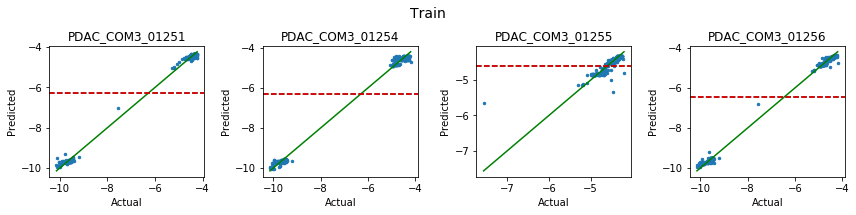

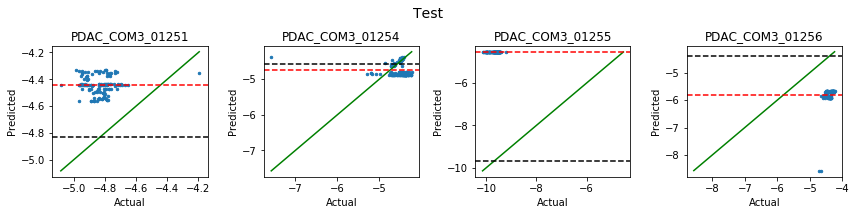

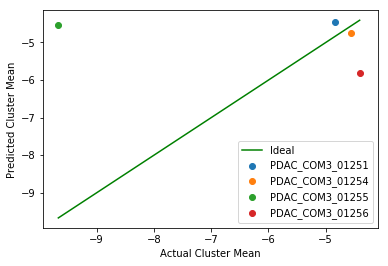

In [46]:
cv_est = RandomForestRegressor(n_estimators=100,min_samples_leaf=2,min_samples_split=5,max_depth=5)
select_est = RandomForestRegressor(n_estimators=100,min_samples_leaf=2,min_samples_split=5,max_depth=5)
k_features = 5

mv.plot_loco_cv_with_selection(cv_est, select_est,Xd_df,y,clusters,k_features,mv.LeaveOneClusterOut,
                         forward=True,
                          floating=True,
                          verbose=2,
                          scoring='r2',
                          n_jobs=4)

Test set: PDAC_COM3_01251


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:    9.5s finished

[2019-03-05 13:08:49] Features: 1/5 -- score: -170.4148186599596[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    9.9s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.5s finished

[2019-03-05 13:09:03] Features: 2/5 -- score: -152.92914199206936[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    9.9s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.6s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.4s finished

[2019-03-05 13:09:21] Features: 2/5 -- score: -40.39556180881066[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    9.7s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    5.0s finished


Test set: PDAC_COM3_01254


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:    9.1s finished

[2019-03-05 13:10:22] Features: 1/5 -- score: -188.98666302447646[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    9.4s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.2s finished

[2019-03-05 13:10:35] Features: 2/5 -- score: -152.41061262352147[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   10.2s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.3s finished

[2019-03-05 13:10:50] Features: 3/5 -- score: -133.59477620478467[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    6.3s finished

[2019-03-05 13:11:08] Features: 4/5 -- score: -126.77502579795811[P

Test set: PDAC_COM3_01255


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:    8.9s finished

[2019-03-05 13:11:37] Features: 1/5 -- score: -0.1996859020354553[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   10.0s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.4s finished

[2019-03-05 13:11:50] Features: 2/5 -- score: 0.09333675771410128[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   10.1s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.7s finished

[2019-03-05 13:12:06] Features: 3/5 -- score: 0.10303084331562806[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:    9.1s finished
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    6.5s finished

[2019-03-05 13:12:23] Features: 4/5 -- score: 0.10902628960242082[P

Test set: PDAC_COM3_01256


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:    9.4s finished

[2019-03-05 13:12:52] Features: 1/5 -- score: -149.87221127024583[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    9.5s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.3s finished

[2019-03-05 13:13:04] Features: 2/5 -- score: -115.79935400340332[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    9.6s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.5s finished

[2019-03-05 13:13:19] Features: 3/5 -- score: -114.47158283114935[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:    9.7s finished
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    6.8s finished

[2019-03-05 13:13:37] Features: 4/5 -- score: -113.67005000832434[P

Train scores:  [0.98713729 0.98628785 0.48817896 0.97761535] 
	Mean train score:  0.8598048625399827
Test scores:  [ -43.62903966   -8.14544884 -715.25710794 -304.02989598] 
	Mean test score:  -267.76537310482513
Selected features:
PDAC_COM3_01251 ['comp_oxmin_goldschmidt_struct', 'comp_oxmedian_goldschmidt_struct', 'Bsite_oxmedian_ion_energy_std', 'Bsite_mass_std', 'comp_melt_temp_mean']
PDAC_COM3_01254 ['comp_oxmax_uc_vol', 'comp_oxmedian_goldschmidt_struct', 'comp_oxstd_uc_vol', 'comp_oxrange_uc_vol', 'comp_oxstd_MX_ABE']
PDAC_COM3_01255 ['Bsite_oxmax_X_cat_std', 'comp_oxmean_X_cat_std', 'comp_mass_mean', 'Bsite_polarizability_std', 'thickness']
PDAC_COM3_01256 ['comp_oxmean_uc_vol_free', 'comp_oxmedian_goldschmidt_struct', 'Bsite_oxmean_ion_energy_std', 'comp_mass_mean', 'comp_polarizability_mean']


{'PDAC_COM3_01251': ['comp_oxmin_goldschmidt_struct',
  'comp_oxmedian_goldschmidt_struct',
  'Bsite_oxmedian_ion_energy_std',
  'Bsite_mass_std',
  'comp_melt_temp_mean'],
 'PDAC_COM3_01254': ['comp_oxmax_uc_vol',
  'comp_oxmedian_goldschmidt_struct',
  'comp_oxstd_uc_vol',
  'comp_oxrange_uc_vol',
  'comp_oxstd_MX_ABE'],
 'PDAC_COM3_01255': ['Bsite_oxmax_X_cat_std',
  'comp_oxmean_X_cat_std',
  'comp_mass_mean',
  'Bsite_polarizability_std',
  'thickness'],
 'PDAC_COM3_01256': ['comp_oxmean_uc_vol_free',
  'comp_oxmedian_goldschmidt_struct',
  'Bsite_oxmean_ion_energy_std',
  'comp_mass_mean',
  'comp_polarizability_mean']}

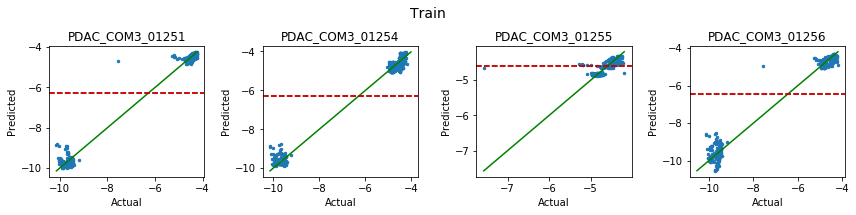

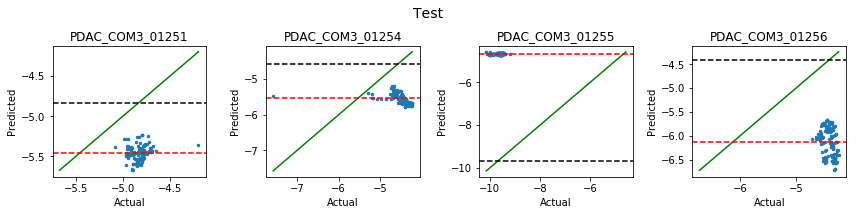

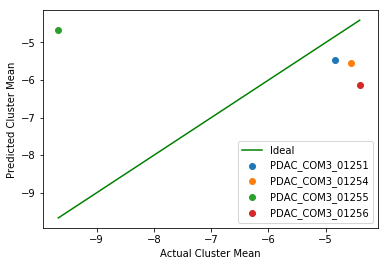

In [49]:
cv_est = Ridge(alpha=10)
select_est = Ridge(alpha=10)
k_features = 5

mv.plot_loco_cv_with_selection(cv_est, select_est,Xd_df,y,clusters,k_features,mv.LeaveOneClusterOut,
                         forward=True,
                          floating=True,
                          verbose=2,
                          scoring='r2',
                          n_jobs=4)

### Back to cheating (feature selection on full dataset with thickness included, then LOCO-CV)

In [50]:
rr = Ridge(alpha=1)
#rr = KernelRidge(alpha=1,kernel='laplacian',degree=3)

sfs = SFS(rr,
          k_features=5,
          forward=True,
          floating=True,
          verbose=2,
          scoring='r2',
          cv=KFold(3,shuffle=True),
          n_jobs=4
)

Xds = ss.fit_transform(Xd_df)

start = time.time()
sfs.fit(Xds,y,custom_feature_names=Xd_df.columns.values)
print('Fit time:',time.time() - start)

[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:    2.1s finished

[2019-03-05 13:28:06] Features: 1/5 -- score: 0.9302369935664782[Parallel(n_jobs=4)]: Done  37 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.6s finished

[2019-03-05 13:28:10] Features: 2/5 -- score: 0.9605245775564647[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    1.0s finished

[2019-03-05 13:28:15] Features: 3/5 -- score: 0.9724638183367403[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 332 out of 332 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    1.4s finished

[2019-03-05 13:28:20] Features: 4/5 -- score: 0.9862497397065649[Paral

Fit time: 24.573569536209106


Test cluster PDAC_COM3_01251
Test cluster PDAC_COM3_01254
Test cluster PDAC_COM3_01255
Test cluster PDAC_COM3_01256
Train scores:  [0.99183764 0.99449813 0.54431039 0.99015499] 
	Mean train score:  0.880200287455059
Test scores:  [-8.40006069e+00  2.11068467e-02 -2.83615391e+02 -6.10316611e+00] 
	Mean test score:  -74.52437763382598


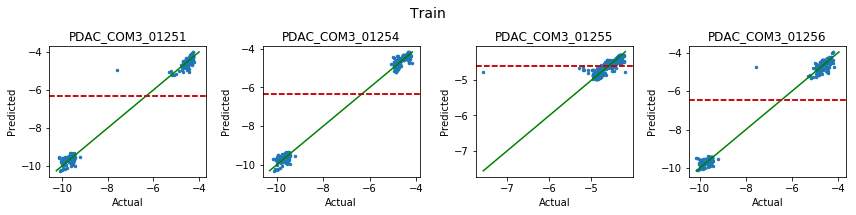

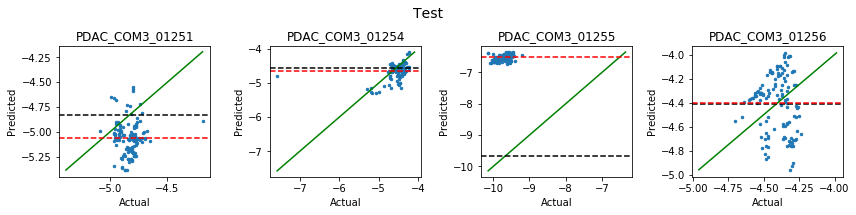

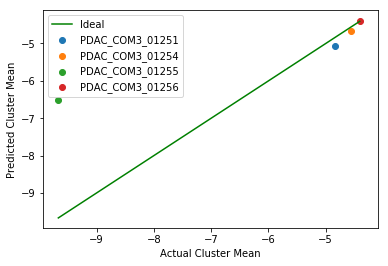

In [55]:
Xd_red = Xd_df.loc[:,list(sfs.k_feature_names_)+['thickness']].values
Xdrs = ss.fit_transform(Xd_red)
mv.plot_loco_cv(Ridge,Xdrs,y,clusters,ncol=4,alpha=1e-1)#e-1)

In [52]:
sfs.subsets_

{1: {'avg_score': 0.9302369935664782,
  'cv_scores': array([0.93300588, 0.93298472, 0.92472038]),
  'feature_idx': (64,),
  'feature_names': ('Bsite_oxmax_r_std',)},
 2: {'avg_score': 0.9605245775564647,
  'cv_scores': array([0.96682944, 0.95178955, 0.96295474]),
  'feature_idx': (24, 64),
  'feature_names': ('comp_oxmean_uc_vol', 'Bsite_oxmax_r_std')},
 3: {'avg_score': 0.9724638183367403,
  'cv_scores': array([0.96524484, 0.97227301, 0.97987361]),
  'feature_idx': (24, 64, 137),
  'feature_names': ('comp_oxmean_uc_vol',
   'Bsite_oxmax_r_std',
   'comp_oxmedian_OS_mean')},
 4: {'avg_score': 0.9862497397065649,
  'cv_scores': array([0.98160913, 0.9914086 , 0.98573149]),
  'feature_idx': (2, 24, 64, 137),
  'feature_names': ('comp_oxmin_tau',
   'comp_oxmean_uc_vol',
   'Bsite_oxmax_r_std',
   'comp_oxmedian_OS_mean')},
 5: {'avg_score': 0.9900124842212957,
  'cv_scores': array([0.99109411, 0.98579116, 0.99315219]),
  'feature_idx': (2, 24, 64, 137, 232),
  'feature_names': ('comp_oxmi

Test cluster PDAC_COM3_01251
Test cluster PDAC_COM3_01254
Test cluster PDAC_COM3_01255
Test cluster PDAC_COM3_01256
Train scores:  [0.99943163 0.99982897 0.94414388 0.99935272] 
	Mean train score:  0.9856893005336759
Test scores:  [-7.77999736e+00 -8.90615099e-02 -2.99603771e+02 -6.13926077e-01] 
	Mean test score:  -77.02168901694112


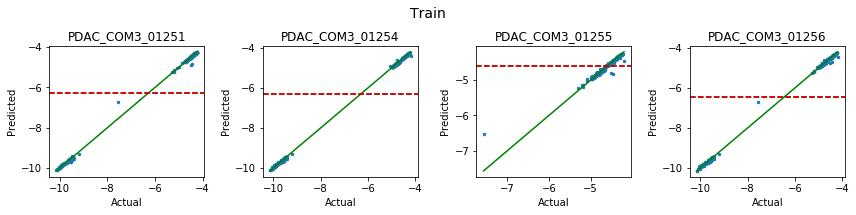

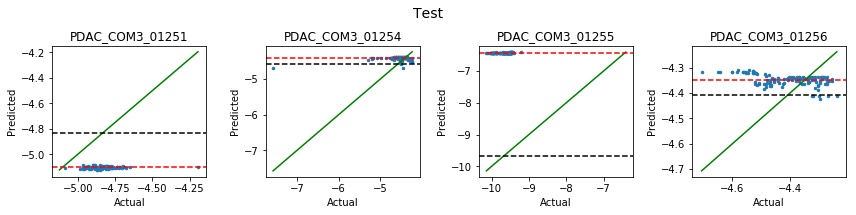

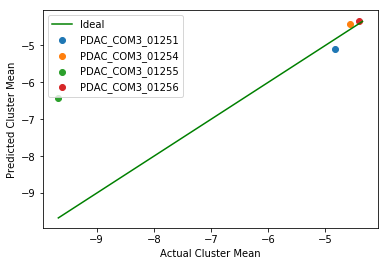

In [69]:
mv.plot_loco_cv(RandomForestRegressor,Xdrs,y,clusters,ncol=4,n_estimators=50)#e-1)

Test cluster PDAC_COM3_01251
Test cluster PDAC_COM3_01254
Test cluster PDAC_COM3_01255
Test cluster PDAC_COM3_01256
Train scores:  [0.99999939 0.99999918 0.99996593 0.99999905] 
	Mean train score:  0.9999908888164648
Test scores:  [ -2.79365631  -0.14962831 -95.42343392  -2.61222947] 
	Mean test score:  -25.24473700263739


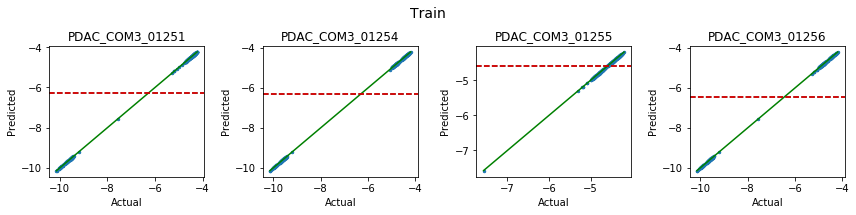

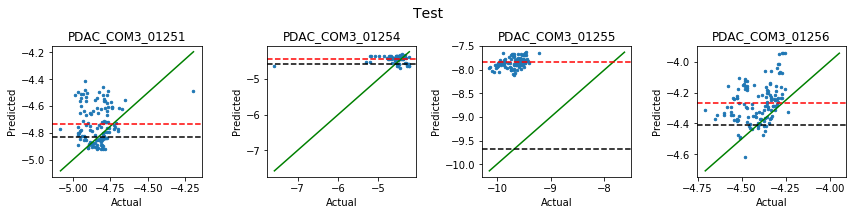

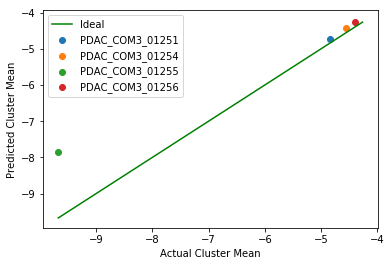

In [70]:
mv.plot_loco_cv(GradientBoostingRegressor,Xdrs,y,clusters,ncol=4,learning_rate=0.9)#e-1)

0.9980307237654472


<IPython.core.display.Javascript object>


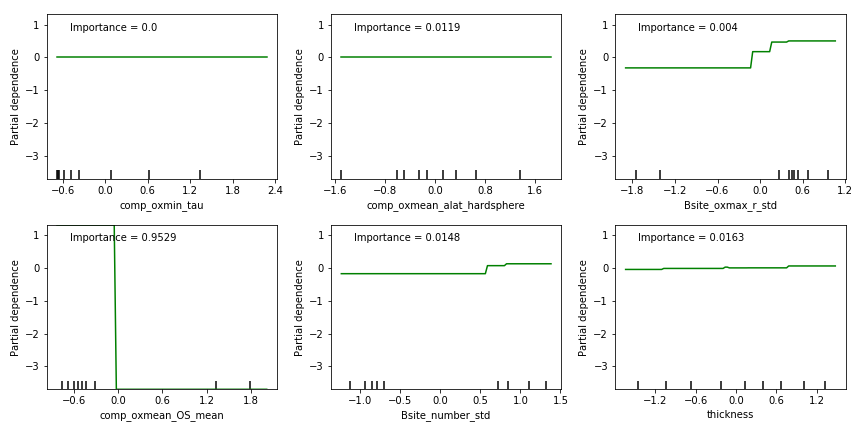

In [348]:
gbr = GradientBoostingRegressor(n_estimators=2,learning_rate=0.9)
gbr.fit(Xdrs,y)
print(gbr.score(Xdrs,y))
fig, axes = plot_partial_dependence(gbr,Xdrs,features=[0,1,2,3,4,5],feature_names=list(sfs.k_feature_names_) + ['thickness'],n_cols=3)
fig.set_size_inches(12,6)
fig.tight_layout()

for ax,imp in zip(axes,gbr.feature_importances_):
    ax.text(0.1,0.9,"Importance = {}".format(round(imp,4)),ha='left',transform=ax.transAxes)

0.9981066153308927


<IPython.core.display.Javascript object>


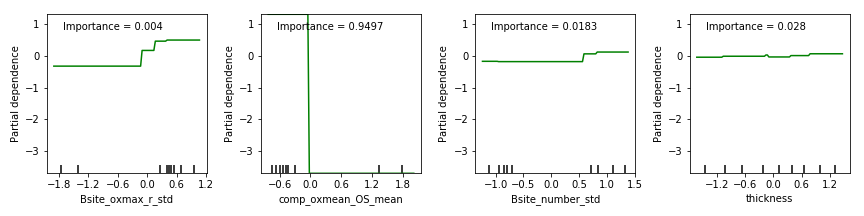

In [346]:
gbr = GradientBoostingRegressor(n_estimators=2,learning_rate=0.9)

gb_features = [
 'Bsite_oxmax_r_std',
 'comp_oxmean_OS_mean',
 'Bsite_number_std',
 'thickness']

X_tmp = ss.fit_transform(Xd_df.loc[:,gb_features])
gbr.fit(X_tmp,y)
print(gbr.score(X_tmp,y))
fig, axes = plot_partial_dependence(gbr,X_tmp,features=[0,1,2,3],feature_names=gb_features,n_cols=4)
fig.set_size_inches(12,3)
fig.tight_layout()

for ax,imp in zip(axes,gbr.feature_importances_):
    ax.text(0.1,0.9,"Importance = {}".format(round(imp,4)),ha='left',transform=ax.transAxes)

0.8723753379567192


<IPython.core.display.Javascript object>


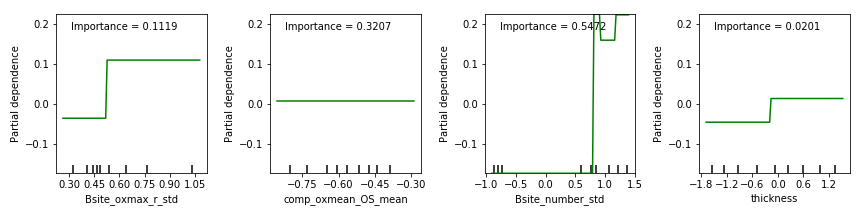

<IPython.core.display.Javascript object>


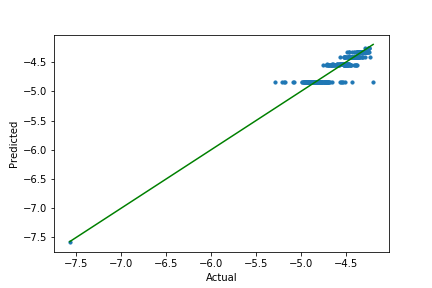

<IPython.core.display.Javascript object>


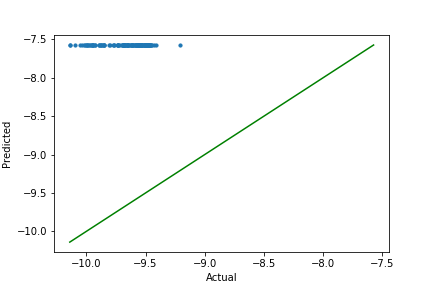

In [378]:
gbr = GradientBoostingRegressor(n_estimators=1,learning_rate=1)

gb_features = [
 'Bsite_oxmax_r_std',
 'comp_oxmean_OS_mean',
 'Bsite_number_std',
 'thickness']

test_cluster = 'PDAC_COM3_01255'
train_idx = np.where(clusters!=test_cluster)
test_idx = np.where(clusters==test_cluster)
X_tmp = Xd_df.loc[:,gb_features].values
X_tmp = ss.fit_transform(X_tmp)
gbr.fit(X_tmp[train_idx],y[train_idx])
print(gbr.score(X_tmp[train_idx],y[train_idx]))
fig, axes = plot_partial_dependence(gbr,X_tmp[train_idx],features=np.arange(len(gb_features)),feature_names=gb_features,n_cols=4)
fig.set_size_inches(12,3)
fig.tight_layout()

for ax,imp in zip(axes,gbr.feature_importances_):
    ax.text(0.1,0.9,"Importance = {}".format(round(imp,4)),ha='left',transform=ax.transAxes)
    
mv.plot_pva(gbr,X_tmp[train_idx],y[train_idx])
mv.plot_pva(gbr,X_tmp[test_idx],y[test_idx])


<IPython.core.display.Javascript object>


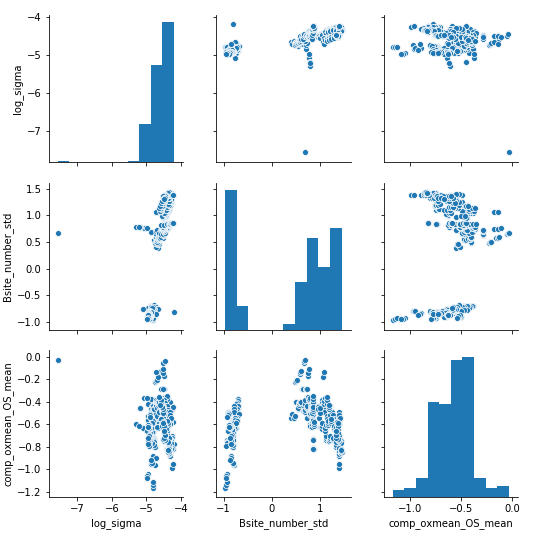

In [388]:
X_tmp_df = pd.DataFrame(X_tmp,columns=gb_features)
X_tmp_df['log_sigma'] = y
sns.pairplot(X_tmp_df.iloc[train_idx[0],:],vars=['log_sigma','Bsite_number_std','comp_oxmean_OS_mean'])

In [391]:
mg.Element('Zr').data['Shannon radii']['4']['VI'],mg.Element('Y').data['Shannon radii']['3']['VI']

({'': {'crystal_radius': 0.86, 'ionic_radius': 0.72}},
 {'': {'crystal_radius': 1.04, 'ionic_radius': 0.9}})

In [394]:
mg.Element('Co').data['Shannon radii'],mg.Element('Fe').data['Shannon radii']

({'2': {'IV': {'High Spin': {'crystal_radius': 0.72, 'ionic_radius': 0.58}},
   'V': {'': {'crystal_radius': 0.81, 'ionic_radius': 0.67}},
   'VI': {'High Spin': {'crystal_radius': 0.885, 'ionic_radius': 0.745},
    'Low Spin': {'crystal_radius': 0.79, 'ionic_radius': 0.65}},
   'VIII': {'': {'crystal_radius': 1.04, 'ionic_radius': 0.9}}},
  '3': {'VI': {'High Spin': {'crystal_radius': 0.75, 'ionic_radius': 0.61},
    'Low Spin': {'crystal_radius': 0.685, 'ionic_radius': 0.545}}},
  '4': {'IV': {'': {'crystal_radius': 0.54, 'ionic_radius': 0.4}},
   'VI': {'High Spin': {'crystal_radius': 0.67, 'ionic_radius': 0.53}}}},
 {'2': {'IV': {'High Spin': {'crystal_radius': 0.77, 'ionic_radius': 0.63}},
   'IVSQ': {'High Spin': {'crystal_radius': 0.78, 'ionic_radius': 0.64}},
   'VI': {'High Spin': {'crystal_radius': 0.92, 'ionic_radius': 0.78},
    'Low Spin': {'crystal_radius': 0.75, 'ionic_radius': 0.61}},
   'VIII': {'High Spin': {'crystal_radius': 1.06, 'ionic_radius': 0.92}}},
  '3': {'IV

# LASSO/elastic net feature selection

<IPython.core.display.Javascript object>


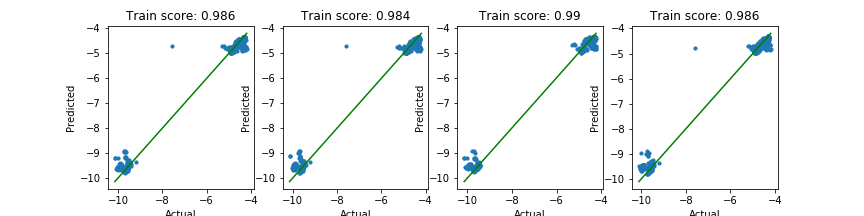

<IPython.core.display.Javascript object>


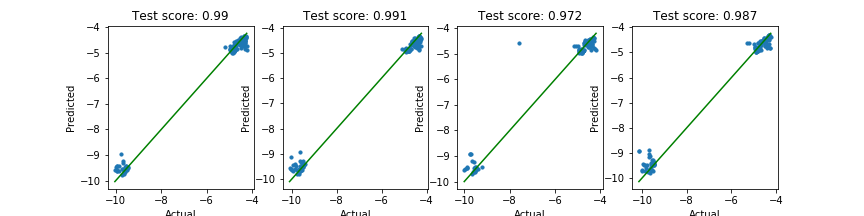

12
11
12
12


In [294]:
en = ElasticNet(alpha=0.1,l1_ratio=0.98,max_iter=5000)
k = 4
ncol = 4
standardize = True

ss = StandardScaler()
kf = KFold(k,shuffle=True)

nrow = int(np.ceil(k/ncol))
fig1, axes1 = plt.subplots(nrow,ncol,figsize=(ncol*3,nrow*3))
fig2, axes2 = plt.subplots(nrow,ncol,figsize=(ncol*3,nrow*3))

selected_cols = []
for ax1,ax2, (train_idx,test_idx) in zip(axes1.ravel(),axes2.ravel(),kf.split(y)):
    X_train = Xd_df.values[train_idx]
    y_train = y[train_idx]
    X_test = Xd_df.values[test_idx]
    y_test = y[test_idx]
    if standardize==True:
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)
    en.fit(X_train,y_train)
    train_score = en.score(X_train,y_train)
    test_score = en.score(X_test,y_test)
    mv.plot_pva(en,X_train,y_train,ax=ax1)
    mv.plot_pva(en,X_test,y_test,ax=ax2)
    ax1.set_title('Train score: {}'.format(round(train_score,3)))
    ax2.set_title('Test score: {}'.format(round(test_score,3)))
    nonzero_idx = np.where(en.coef_!=0)
    nonzero_col = Xd_df.columns.values[nonzero_idx]
    print(len(nonzero_col))
    selected_cols.append(nonzero_col)
    

In [295]:
selected_cols

[array(['comp_oxmedian_alat_hardsphere', 'comp_oxmedian_uc_vol',
        'Bsite_oxmean_X_cat_std', 'Bsite_oxstd_r_std',
        'comp_oxmax_X_cat_std', 'comp_oxmean_X_cat_std', 'Bsite_mass_std',
        'comp_X_mean', 'comp_mass_std', 'Bsite_valence_elec_s_frac',
        'Bsite_valence_elec_d_frac', 'comp_sigma_therm_std'], dtype=object),
 array(['comp_oxmedian_alat_hardsphere', 'comp_oxmedian_uc_vol',
        'Bsite_oxmean_X_cat_std', 'Bsite_oxstd_r_std',
        'comp_oxmax_X_cat_std', 'Bsite_mass_std', 'comp_X_mean',
        'comp_mass_std', 'Bsite_valence_elec_s_frac',
        'Bsite_valence_elec_d_frac', 'comp_sigma_therm_std'], dtype=object),
 array(['comp_oxmedian_alat_hardsphere', 'comp_oxmedian_uc_vol',
        'Bsite_oxmean_X_cat_std', 'Bsite_oxstd_r_std',
        'comp_oxmax_X_cat_std', 'comp_oxmean_X_cat_std', 'Bsite_mass_std',
        'comp_X_mean', 'comp_mass_std', 'Bsite_valence_elec_s_frac',
        'Bsite_valence_elec_d_frac', 'comp_sigma_therm_std'], dtype=object),
 a

In [248]:
Xd_df

,comp_oxmin_goldschmidt,comp_oxmin_goldschmidt_struct,comp_oxmin_tau,comp_oxmin_tot_cat_charge,comp_oxmin_anion_delta,comp_oxmin_alat_hardsphere,comp_oxmin_uc_vol,comp_oxmin_uc_vol_free,comp_oxmin_r_crit,comp_oxmax_goldschmidt,...,comp_valence_unfilled_f_mean,comp_valence_unfilled_f_std,comp_valence_unfilled_f_range,comp_polarizability_mean,comp_polarizability_std,comp_polarizability_range,comp_sigma_therm_mean,comp_sigma_therm_std,comp_sigma_therm_range,thickness
1_500C_dry_1251,0.992770,2.0,3.420198,4.199360,0.033390,4.186072,73.353379,24.475398,0.886408,1.083702,...,0.0,0.0,0.0,10.085616,19.683882,38.898,19.680210,43.338016,99.97342,0.112290
2_500C_dry_1251,0.992760,2.0,3.420200,4.201362,0.032380,4.186072,73.353379,24.464849,0.886424,1.083683,...,0.0,0.0,0.0,10.091678,19.688179,38.898,19.677289,43.323369,99.97342,0.114887
3_500C_dry_1251,0.992749,2.0,3.420202,4.203340,0.031390,4.186072,73.353379,24.454493,0.886440,1.083663,...,0.0,0.0,0.0,10.097750,19.692388,38.898,19.674496,43.308683,99.97342,0.117484
4_500C_dry_1251,0.992785,2.0,3.420195,4.177100,0.032340,4.186072,73.353379,24.476583,0.886387,1.085298,...,0.0,0.0,0.0,10.064643,19.686528,38.898,19.907178,43.756259,99.97342,0.119250
5_500C_dry_1251,0.992809,2.0,3.420190,4.180578,0.032150,4.186072,73.353379,24.473465,0.886352,1.085143,...,0.0,0.0,0.0,10.069012,19.687442,38.898,19.884647,43.717985,99.97342,0.122203
6_500C_dry_1251,0.992833,2.0,3.420186,4.184080,0.031940,4.186072,73.353379,24.470151,0.886317,1.084989,...,0.0,0.0,0.0,10.073370,19.688442,38.898,19.861950,43.679624,99.97342,0.125156
7_500C_dry_1251,0.993292,2.0,3.420108,4.196000,0.033970,4.186072,73.353379,24.489810,0.885639,1.084821,...,0.0,0.0,0.0,10.073977,19.680246,38.898,19.828070,43.729342,99.97342,0.125930
8_500C_dry_1251,0.993303,2.0,3.420107,4.197640,0.033550,4.186072,73.353379,24.485245,0.885624,1.084789,...,0.0,0.0,0.0,10.077254,19.682051,38.898,19.823163,43.719530,99.97342,0.129211
9_500C_dry_1251,0.993314,2.0,3.420105,4.199260,0.033140,4.186072,73.353379,24.480782,0.885608,1.084758,...,0.0,0.0,0.0,10.080472,19.683812,38.898,19.818261,43.709798,99.97342,0.132492
10_500C_dry_1251,0.993352,2.0,3.420100,4.182440,0.029420,4.186072,73.353379,24.454659,0.885551,1.086396,...,0.0,0.0,0.0,10.075270,19.699216,38.898,20.049028,44.119827,99.97342,0.129340
